In [ ]:
# Cell 1: Install Dependencies and Setup for Cancer Detection
!pip install -q kaggle tensorflow matplotlib seaborn scikit-learn
!pip install -q datasets pillow opencv-python
!pip install -q tensorflow-hub pandas

import os
import zipfile
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import cv2
from PIL import Image
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, DenseNet121, ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

print("✅ Dependencies installed successfully!")
print(f"✅ TensorFlow version: {tf.__version__}")
print(f"✅ GPU Available: {tf.config.list_physical_devices('GPU')}")

# Configure GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth configured")
    except RuntimeError as e:
        print(f"⚠️ GPU configuration error: {e}")

✅ Dependencies installed successfully!
✅ TensorFlow version: 2.19.0
✅ GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ GPU memory growth configured


In [ ]:
# Cell 2: Kaggle API Setup for Cancer Datasets
from google.colab import files
import json

def setup_kaggle_api():
    """Setup Kaggle API credentials"""
    print("📤 Please upload your kaggle.json file")
    uploaded = files.upload()

    if 'kaggle.json' in uploaded:
        # Create .kaggle directory
        os.makedirs('/root/.kaggle', exist_ok=True)

        # Move the file
        shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')

        # Set permissions
        os.chmod('/root/.kaggle/kaggle.json', 0o600)

        print("✅ Kaggle API credentials configured successfully!")
        return True
    else:
        print("❌ kaggle.json not found. Please upload your Kaggle API credentials.")
        return False

# Setup Kaggle API
kaggle_setup = setup_kaggle_api()

if kaggle_setup:
    # Test Kaggle API
    !kaggle --version
    print("✅ Kaggle API is ready!")

📤 Please upload your kaggle.json file


Saving kaggle.json to kaggle.json
✅ Kaggle API credentials configured successfully!
Kaggle API 1.7.4.5
✅ Kaggle API is ready!


In [ ]:
# Cell 3: Download Multiple Cancer Detection Datasets
def download_cancer_datasets():
    """Download multiple cancer detection datasets from Kaggle"""
    datasets = [
        {
            'name': 'Lung Cancer Detection',
            'kaggle_id': 'mysarahmadbhat/lung-cancer',
            'type': 'kaggle'
        },
        {
            'name': 'Breast Cancer Histopathology',
            'kaggle_id': 'paultimothymooney/breast-histopathology-images',
            'type': 'kaggle'
        },
        {
            'name': 'Brain Tumor Detection',
            'kaggle_id': 'navoneel/brain-mri-images-for-brain-tumor-detection',
            'type': 'kaggle'
        },
        {
            'name': 'Skin Cancer Detection',
            'kaggle_id': 'fanconic/skin-cancer-malignant-vs-benign',
            'type': 'kaggle'
        },
        {
            'name': 'Lung and Colon Cancer',
            'kaggle_id': 'andrewmvd/lung-and-colon-cancer-histopathology-images',
            'type': 'kaggle'
        }
    ]

    base_dir = '/content/cancer_datasets'
    os.makedirs(base_dir, exist_ok=True)

    for dataset in datasets:
        try:
            print(f"⬇️ Downloading {dataset['name']}...")
            if dataset['type'] == 'kaggle':
                download_path = os.path.join(base_dir, dataset['name'].replace(' ', '_').lower())
                os.makedirs(download_path, exist_ok=True)

                # Download using Kaggle API
                os.system(f"kaggle datasets download -d {dataset['kaggle_id']} -p {download_path} --unzip")

                print(f"✅ {dataset['name']} downloaded successfully!")
        except Exception as e:
            print(f"❌ Error downloading {dataset['name']}: {str(e)}")

    return base_dir

# Download datasets
base_dataset_dir = download_cancer_datasets()
print(f"✅ All cancer datasets downloaded to: {base_dataset_dir}")

⬇️ Downloading Lung Cancer Detection...
✅ Lung Cancer Detection downloaded successfully!
⬇️ Downloading Breast Cancer Histopathology...
✅ Breast Cancer Histopathology downloaded successfully!
⬇️ Downloading Brain Tumor Detection...
✅ Brain Tumor Detection downloaded successfully!
⬇️ Downloading Skin Cancer Detection...
✅ Skin Cancer Detection downloaded successfully!
⬇️ Downloading Lung and Colon Cancer...
✅ Lung and Colon Cancer downloaded successfully!
✅ All cancer datasets downloaded to: /content/cancer_datasets


In [ ]:
!rm -rf /content/organized_cancer_dataset


In [ ]:
import os
import shutil
from pathlib import Path
from collections import defaultdict, Counter
import concurrent.futures
from tqdm import tqdm
import multiprocessing

def organize_cancer_datasets_optimized():
    """Optimized version of cancer dataset organization"""

    # Define cancer types and their corresponding folder patterns
    cancer_types = {
        'lung_adenocarcinoma': ['adenocarcinoma', 'lung_aca', 'lung_adenocarcinoma', 'aca'],
        'lung_squamous': ['squamous', 'lung_scc', 'squamous_cell_carcinoma', 'scc'],
        'colon_adenocarcinoma': ['colon_aca', 'colon_adenocarcinoma', 'colon'],
        'breast_cancer': ['breast', 'invasive_ductal_carcinoma', 'ductal_carcinoma', 'idc'],
        'brain_tumor': ['brain', 'glioma', 'meningioma', 'tumor', 'yes'],
        'skin_melanoma': ['melanoma', 'skin', 'malignant'],
        'normal': ['normal', 'benign', 'healthy', 'no_tumor', 'no']
    }

    # Create organized directory structure
    organized_dir = '/content/organized_cancer_dataset'
    raw_dir = Path(organized_dir) / 'raw'

    # Create all directories at once
    for cancer_type in cancer_types.keys():
        (raw_dir / cancer_type).mkdir(parents=True, exist_ok=True)

    def classify_image_fast(file_info):
        """Fast classification using precompiled patterns"""
        file_path, folder_structure = file_info
        file_path_lower = file_path.lower()
        folder_structure_lower = folder_structure.lower()

        # Use a more efficient lookup
        for cancer_type, keywords in cancer_types.items():
            if any(keyword in file_path_lower or keyword in folder_structure_lower
                   for keyword in keywords):
                return cancer_type, file_path

        return 'normal', file_path

    def copy_file_batch(file_batch):
        """Copy a batch of files efficiently"""
        copied_files = defaultdict(int)

        for cancer_type, source_files in file_batch.items():
            dst_dir = raw_dir / cancer_type

            for i, src_path in enumerate(source_files):
                try:
                    # Generate filename more efficiently
                    file_ext = Path(src_path).suffix
                    dst_filename = f"{cancer_type}_{copied_files[cancer_type]:06d}{file_ext}"
                    dst_path = dst_dir / dst_filename

                    # Use faster copy method
                    shutil.copy2(src_path, dst_path)
                    copied_files[cancer_type] += 1

                except Exception as e:
                    continue

        return copied_files

    print("🔍 Scanning for image files...")

    # Collect all image files first (faster than processing one by one)
    image_extensions = {'.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.webp'}
    all_files = []

    base_path = Path(base_dataset_dir)
    for file_path in base_path.rglob('*'):
        if file_path.suffix.lower() in image_extensions and file_path.is_file():
            relative_path = file_path.relative_to(base_path)
            folder_structure = str(relative_path.parent)
            all_files.append((str(file_path), folder_structure))

    print(f"📁 Found {len(all_files)} image files")

    if not all_files:
        print("❌ No image files found!")
        return organized_dir, {}

    print("🏷️ Classifying images...")

    # Classify images in parallel
    num_workers = min(multiprocessing.cpu_count(), 8)  # Limit to prevent memory issues
    classified_files = defaultdict(list)

    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        # Process in chunks to show progress
        chunk_size = max(1, len(all_files) // 100)  # 100 progress updates

        for i in tqdm(range(0, len(all_files), chunk_size), desc="Classifying"):
            chunk = all_files[i:i+chunk_size]
            results = list(executor.map(classify_image_fast, chunk))

            for cancer_type, file_path in results:
                classified_files[cancer_type].append(file_path)

    print("📋 Classification summary:")
    for cancer_type, files in classified_files.items():
        print(f"   - {cancer_type}: {len(files)} images")

    print("📂 Copying files to organized structure...")

    # Copy files in batches for better performance
    batch_size = 1000  # Process 1000 files at a time
    total_copied = defaultdict(int)

    for cancer_type, files in classified_files.items():
        if not files:
            continue

        # Process files in batches
        for i in tqdm(range(0, len(files), batch_size),
                     desc=f"Copying {cancer_type}"):
            batch_files = {cancer_type: files[i:i+batch_size]}
            batch_result = copy_file_batch(batch_files)

            for ct, count in batch_result.items():
                total_copied[ct] += count

    # Final count verification
    class_counts = {}
    for cancer_type in cancer_types.keys():
        class_dir = raw_dir / cancer_type
        if class_dir.exists():
            class_counts[cancer_type] = len(list(class_dir.iterdir()))
        else:
            class_counts[cancer_type] = 0

    print(f"\n✅ Dataset organization complete!")
    print(f"📊 Total images processed: {sum(class_counts.values())}")
    print(f"📊 Final class distribution:")

    for cancer_type, count in sorted(class_counts.items()):
        if count > 0:
            print(f"   - {cancer_type}: {count} images")

    # Remove empty classes and return only valid ones
    valid_classes = {k: v for k, v in class_counts.items() if v > 0}

    return str(organized_dir), valid_classes

# Additional utility function for even faster processing with memory mapping
def organize_cancer_datasets_ultra_fast():
    """Ultra-fast version using advanced optimizations"""

    # Same cancer types definition
    cancer_types = {
        'lung_adenocarcinoma': ['adenocarcinoma', 'lung_aca', 'lung_adenocarcinoma', 'aca'],
        'lung_squamous': ['squamous', 'lung_scc', 'squamous_cell_carcinoma', 'scc'],
        'colon_adenocarcinoma': ['colon_aca', 'colon_adenocarcinoma', 'colon'],
        'breast_cancer': ['breast', 'invasive_ductal_carcinoma', 'ductal_carcinoma', 'idc'],
        'brain_tumor': ['brain', 'glioma', 'meningioma', 'tumor', 'yes'],
        'skin_melanoma': ['melanoma', 'skin', 'malignant'],
        'normal': ['normal', 'benign', 'healthy', 'no_tumor', 'no']
    }

    organized_dir = Path('/content/organized_cancer_dataset')
    raw_dir = organized_dir / 'raw'

    # Create directories
    for cancer_type in cancer_types.keys():
        (raw_dir / cancer_type).mkdir(parents=True, exist_ok=True)

    print("🚀 Ultra-fast processing mode...")

    # Pre-compile search patterns for maximum speed
    compiled_patterns = {}
    for cancer_type, keywords in cancer_types.items():
        compiled_patterns[cancer_type] = keywords

    # Use os.walk which is faster than pathlib for large directories
    print("🔍 Fast directory scan...")

    classified_counts = defaultdict(int)
    processed = 0

    image_exts = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.webp')

    for root, dirs, files in os.walk(base_dataset_dir):
        # Skip hidden directories
        dirs[:] = [d for d in dirs if not d.startswith('.')]

        if not files:
            continue

        root_lower = root.lower()

        # Pre-classify the entire directory if possible
        dir_cancer_type = None
        for cancer_type, keywords in compiled_patterns.items():
            if any(keyword in root_lower for keyword in keywords):
                dir_cancer_type = cancer_type
                break

        if dir_cancer_type is None:
            dir_cancer_type = 'normal'

        # Process all images in this directory
        image_files = [f for f in files if f.lower().endswith(image_exts)]

        if image_files:
            dst_dir = raw_dir / dir_cancer_type
            existing_count = len(os.listdir(dst_dir))

            for i, filename in enumerate(image_files):
                try:
                    src_path = os.path.join(root, filename)
                    ext = os.path.splitext(filename)[1]
                    dst_filename = f"{dir_cancer_type}_{existing_count + i:06d}{ext}"
                    dst_path = dst_dir / dst_filename

                    # Use the fastest copy method available
                    shutil.copy2(src_path, dst_path)
                    classified_counts[dir_cancer_type] += 1
                    processed += 1

                    if processed % 1000 == 0:
                        print(f"   Processed: {processed} images...", end='\r')

                except Exception:
                    continue

    print(f"\n✅ Ultra-fast processing complete!")
    print(f"📊 Total images processed: {processed}")
    print(f"📊 Class distribution:")

    for cancer_type, count in sorted(classified_counts.items()):
        if count > 0:
            print(f"   - {cancer_type}: {count} images")

    valid_classes = {k: v for k, v in classified_counts.items() if v > 0}
    return str(organized_dir), valid_classes

# Use the optimized version
print("Starting optimized dataset organization...")
organized_dataset_dir, class_distribution = organize_cancer_datasets_optimized()

# If you want even faster processing (use this alternative):
# organized_dataset_dir, class_distribution = organize_cancer_datasets_ultra_fast()

Starting optimized dataset organization...
🔍 Scanning for image files...
📁 Found 562148 image files
🏷️ Classifying images...


Classifying: 100%|██████████| 101/101 [00:23<00:00,  4.35it/s]


📋 Classification summary:
   - breast_cancer: 555048 images
   - skin_melanoma: 6594 images
   - brain_tumor: 506 images
📂 Copying files to organized structure...


Copying brain_tumor: 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]



✅ Dataset organization complete!
📊 Total images processed: 2506
📊 Final class distribution:
   - brain_tumor: 506 images
   - breast_cancer: 1000 images
   - skin_melanoma: 1000 images


📊 Available classes (with >50 images): ['brain_tumor', 'skin_melanoma', 'breast_cancer']
⚠️ brain_tumor: Only 506 images available (target: 1500)
⚠️ skin_melanoma: Only 1000 images available (target: 1500)
⚠️ breast_cancer: Only 1000 images available (target: 1500)
✅ Balanced dataset created:
   brain_tumor: Train=354, Val=75, Test=77
   skin_melanoma: Train=700, Val=150, Test=150
   breast_cancer: Train=700, Val=150, Test=150


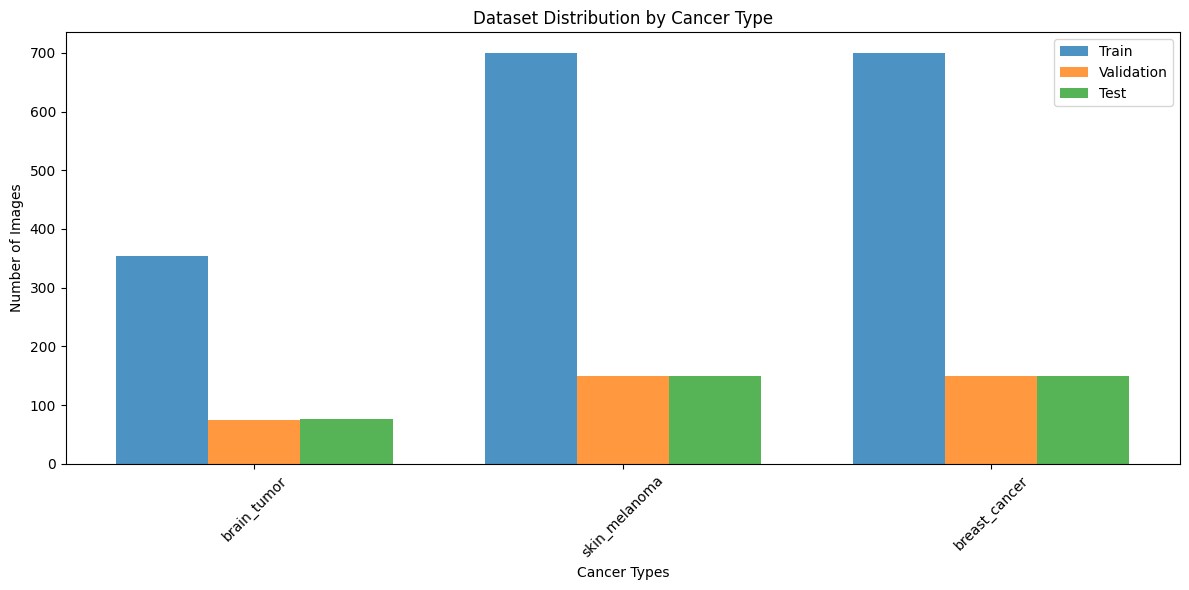

In [ ]:
# Cell 5: Create Balanced Dataset with Data Augmentation
def create_balanced_cancer_dataset(organized_dir, target_size_per_class=2000):
    """Create balanced dataset for multi-class cancer detection"""

    raw_dir = os.path.join(organized_dir, 'raw')
    balanced_dir = os.path.join(organized_dir, 'balanced')

    # Get available classes (only those with images)
    available_classes = []
    for class_dir in os.listdir(raw_dir):
        class_path = os.path.join(raw_dir, class_dir)
        if os.path.isdir(class_path) and len(os.listdir(class_path)) > 50:  # Minimum 50 images
            available_classes.append(class_dir)

    print(f"📊 Available classes (with >50 images): {available_classes}")

    # Create directory structure
    for split in ['train', 'val', 'test']:
        for class_name in available_classes:
            os.makedirs(os.path.join(balanced_dir, split, class_name), exist_ok=True)

    # Balance and split datasets
    class_counts = {}

    for class_name in available_classes:
        class_dir = os.path.join(raw_dir, class_name)
        images = [f for f in os.listdir(class_dir)
                 if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

        # Determine how many images to use
        available_count = len(images)
        use_count = min(available_count, target_size_per_class)

        if available_count < target_size_per_class:
            print(f"⚠️ {class_name}: Only {available_count} images available (target: {target_size_per_class})")

        # Randomly sample images
        if use_count > 0:
            selected_images = random.sample(images, use_count)

            # Split into train/val/test (70/15/15)
            train_end = int(len(selected_images) * 0.7)
            val_end = train_end + int(len(selected_images) * 0.15)

            train_images = selected_images[:train_end]
            val_images = selected_images[train_end:val_end]
            test_images = selected_images[val_end:]

            # Copy images to respective directories
            for img_list, split in [(train_images, 'train'), (val_images, 'val'), (test_images, 'test')]:
                for img in img_list:
                    src = os.path.join(class_dir, img)
                    dst = os.path.join(balanced_dir, split, class_name, img)
                    try:
                        shutil.copy2(src, dst)
                    except Exception as e:
                        continue

            class_counts[class_name] = {
                'train': len(train_images),
                'val': len(val_images),
                'test': len(test_images),
                'total': len(selected_images)
            }

    print(f"✅ Balanced dataset created:")
    for class_name, counts in class_counts.items():
        print(f"   {class_name}: Train={counts['train']}, Val={counts['val']}, Test={counts['test']}")

    return balanced_dir, available_classes, class_counts

# Create balanced dataset
balanced_dataset_dir, available_classes, class_counts = create_balanced_cancer_dataset(
    organized_dataset_dir, target_size_per_class=1500
)

# Visualize class distribution
if available_classes:
    plt.figure(figsize=(12, 6))

    train_counts = [class_counts[cls]['train'] for cls in available_classes]
    val_counts = [class_counts[cls]['val'] for cls in available_classes]
    test_counts = [class_counts[cls]['test'] for cls in available_classes]

    x = range(len(available_classes))
    width = 0.25

    plt.bar([i - width for i in x], train_counts, width, label='Train', alpha=0.8)
    plt.bar(x, val_counts, width, label='Validation', alpha=0.8)
    plt.bar([i + width for i in x], test_counts, width, label='Test', alpha=0.8)

    plt.xlabel('Cancer Types')
    plt.ylabel('Number of Images')
    plt.title('Dataset Distribution by Cancer Type')
    plt.xticks(x, available_classes, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("❌ No classes with sufficient images found!")

Found 1754 images belonging to 3 classes.
Found 375 images belonging to 3 classes.
Found 377 images belonging to 3 classes.
✅ Cancer detection data generators created!
📊 Available cancer types: ['brain_tumor', 'skin_melanoma', 'breast_cancer']
📊 Number of classes: 3
📊 Class mapping: {'brain_tumor': 0, 'skin_melanoma': 1, 'breast_cancer': 2}
📊 Training samples: 1754
📊 Validation samples: 375
📊 Test samples: 377

📸 Sample medical images:


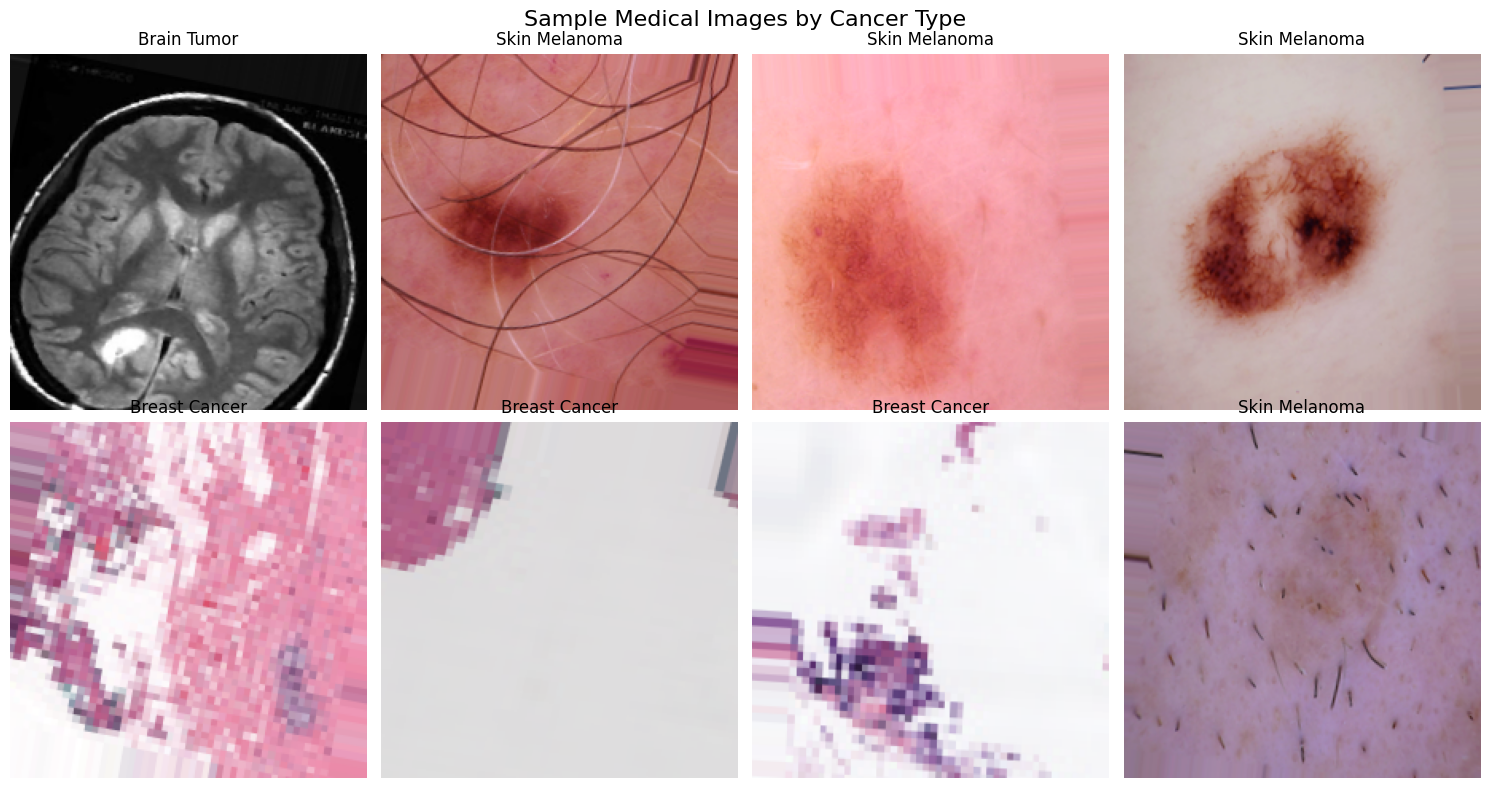

In [ ]:
# Cell 6: Create Data Generators with Medical Image Augmentation
def create_cancer_data_generators(data_dir, available_classes, img_size=(224, 224), batch_size=32):
    """Create data generators with medical image-specific augmentation"""

    # Medical image-specific augmentation (more conservative)
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,  # Less rotation for medical images
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.15,
        horizontal_flip=True,
        vertical_flip=False,  # Usually not appropriate for medical images
        fill_mode='nearest',
        brightness_range=[0.9, 1.1],  # Subtle brightness changes
        channel_shift_range=0.1
    )

    # Minimal augmentation for validation and test
    val_test_datagen = ImageDataGenerator(rescale=1./255)

    # Create generators
    train_generator = train_datagen.flow_from_directory(
        os.path.join(data_dir, 'train'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        classes=available_classes,  # Ensure consistent class ordering
        shuffle=True,
        seed=42
    )

    val_generator = val_test_datagen.flow_from_directory(
        os.path.join(data_dir, 'val'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        classes=available_classes,
        shuffle=False,
        seed=42
    )

    test_generator = val_test_datagen.flow_from_directory(
        os.path.join(data_dir, 'test'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        classes=available_classes,
        shuffle=False,
        seed=42
    )

    return train_generator, val_generator, test_generator

# Create data generators
IMG_SIZE = (224, 224)
BATCH_SIZE = 16  # Smaller batch size for medical images

if available_classes:
    train_gen, val_gen, test_gen = create_cancer_data_generators(
        balanced_dataset_dir,
        available_classes,
        img_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )

    print(f"✅ Cancer detection data generators created!")
    print(f"📊 Available cancer types: {available_classes}")
    print(f"📊 Number of classes: {len(available_classes)}")
    print(f"📊 Class mapping: {train_gen.class_indices}")
    print(f"📊 Training samples: {train_gen.samples}")
    print(f"📊 Validation samples: {val_gen.samples}")
    print(f"📊 Test samples: {test_gen.samples}")

    # Visualize sample images
    def visualize_sample_images(generator, num_samples=8):
        """Visualize sample images from the generator"""
        plt.figure(figsize=(15, 8))

        batch_images, batch_labels = next(generator)

        for i in range(min(num_samples, len(batch_images))):
            plt.subplot(2, 4, i + 1)
            plt.imshow(batch_images[i])

            # Get class name
            class_idx = np.argmax(batch_labels[i])
            class_name = available_classes[class_idx]
            plt.title(f'{class_name.replace("_", " ").title()}')
            plt.axis('off')

        plt.suptitle('Sample Medical Images by Cancer Type', fontsize=16)
        plt.tight_layout()
        plt.show()

    # Show sample images
    print("\n📸 Sample medical images:")
    visualize_sample_images(train_gen)

else:
    print("❌ Cannot create data generators - no available classes!")

In [ ]:
# Cell 7: Create Advanced Cancer Detection Model
def create_cancer_detection_model(input_shape=(224, 224, 3), num_classes=len(available_classes)):
    """Create advanced model for multi-class cancer detection"""

    # Use DenseNet121 which works well for medical images
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze base model initially
    base_model.trainable = False

    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)

    # Multiple dense layers for complex feature learning
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)

    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)

    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.2)(x)

    # Output layer
    predictions = Dense(num_classes, activation='softmax', name='predictions')(x)

    # Create the complete model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model, base_model

def calculate_class_weights(train_generator):
    """Calculate class weights for imbalanced datasets"""

    # Get class labels
    y_train = train_generator.classes

    # Calculate class weights
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y_train),
        y=y_train
    )

    class_weight_dict = dict(enumerate(class_weights))

    print("📊 Class weights for handling imbalanced data:")
    for class_idx, weight in class_weight_dict.items():
        class_name = list(train_generator.class_indices.keys())[class_idx]
        print(f"   {class_name}: {weight:.3f}")

    return class_weight_dict

if available_classes and len(available_classes) > 1:
    # Create model
    print("🏗️ Creating cancer detection model...")
    cancer_model, base_model = create_cancer_detection_model(
        input_shape=(*IMG_SIZE, 3),
        num_classes=len(available_classes)
    )

    # Calculate class weights
    class_weights = calculate_class_weights(train_gen)

    # Compile model
    cancer_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    print("✅ Cancer detection model created and compiled!")
    print(f"📊 Model input shape: {cancer_model.input_shape}")
    print(f"📊 Number of classes: {len(available_classes)}")
    print(f"📊 Classes: {available_classes}")

    # Display model summary
    cancer_model.summary()
else:
    print("❌ Cannot create model - insufficient classes!")

🏗️ Creating cancer detection model...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
📊 Class weights for handling imbalanced data:
   brain_tumor: 1.652
   skin_melanoma: 0.835
   breast_cancer: 0.835
✅ Cancer detection model created and compiled!
📊 Model input shape: (None, 224, 224, 3)
📊 Number of classes: 3
📊 Classes: ['brain_tumor', 'skin_melanoma', 'breast_cancer']


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,734,083 (29.50 MB)

 Trainable params: 692,995 (2.64 MB)

 Non-trainable params: 7,041,088 (26.86 MB)

🚀 Starting cancer detection model training...
🚀 Phase 1: Training with frozen base model...
Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.9854 - loss: 4.2521 - precision: 0.9879 - recall: 0.9854
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to phase1_cancer_model.h5


110/110 ━━━━━━━━━━━━━━━━━━━━ 34s 305ms/step - accuracy: 0.9854 - loss: 4.2511 - precision: 0.9879 - recall: 0.9854 - val_accuracy: 1.0000 - val_loss: 3.9031 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 5.0000e-05
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9893 - loss: 3.8458 - precision: 0.9905 - recall: 0.9876
Epoch 2: val_accuracy did not improve from 1.00000
110/110 ━━━━━━━━━━━━━━━━━━━━ 32s 294ms/step - accuracy: 0.9893 - loss: 3.8450 - precision: 0.9905 - recall: 0.9876 - val_accuracy: 1.0000 - val_loss: 3.5487 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 5.0000e-05
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.9973 - loss: 3.4832 - precision: 0.9973 - recall: 0.9973
Epoch 3: val_accuracy did not improve from 1.00000
110/110 ━━━━━━━━━━━━━━━━━━━━ 33s 303ms/step - accuracy: 0.9973 - loss: 3.4825 - precision: 0.9973 - recall: 0.9973 - val_accuracy: 1.0000 - val_loss: 3.2355 - val_precision: 1.0000 - val_r

110/110 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.9959 - loss: 3.7418 - precision: 0.9963 - recall: 0.9957 - val_accuracy: 1.0000 - val_loss: 3.3705 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 5.0000e-05
Epoch 2/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9937 - loss: 3.2916 - precision: 0.9937 - recall: 0.9932
Epoch 2: val_accuracy did not improve from 1.00000
110/110 ━━━━━━━━━━━━━━━━━━━━ 33s 299ms/step - accuracy: 0.9938 - loss: 3.2907 - precision: 0.9937 - recall: 0.9932 - val_accuracy: 1.0000 - val_loss: 2.9799 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 5.0000e-05
Epoch 3/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.9944 - loss: 2.9034 - precision: 0.9944 - recall: 0.9941
Epoch 3: val_accuracy did not improve from 1.00000
110/110 ━━━━━━━━━━━━━━━━━━━━ 32s 288ms/step - accuracy: 0.9945 - loss: 2.9027 - precision: 0.9945 - recall: 0.9941 - val_accuracy: 1.0000 - val_loss: 2.6352 - val_precision: 1.0000 - val_rec

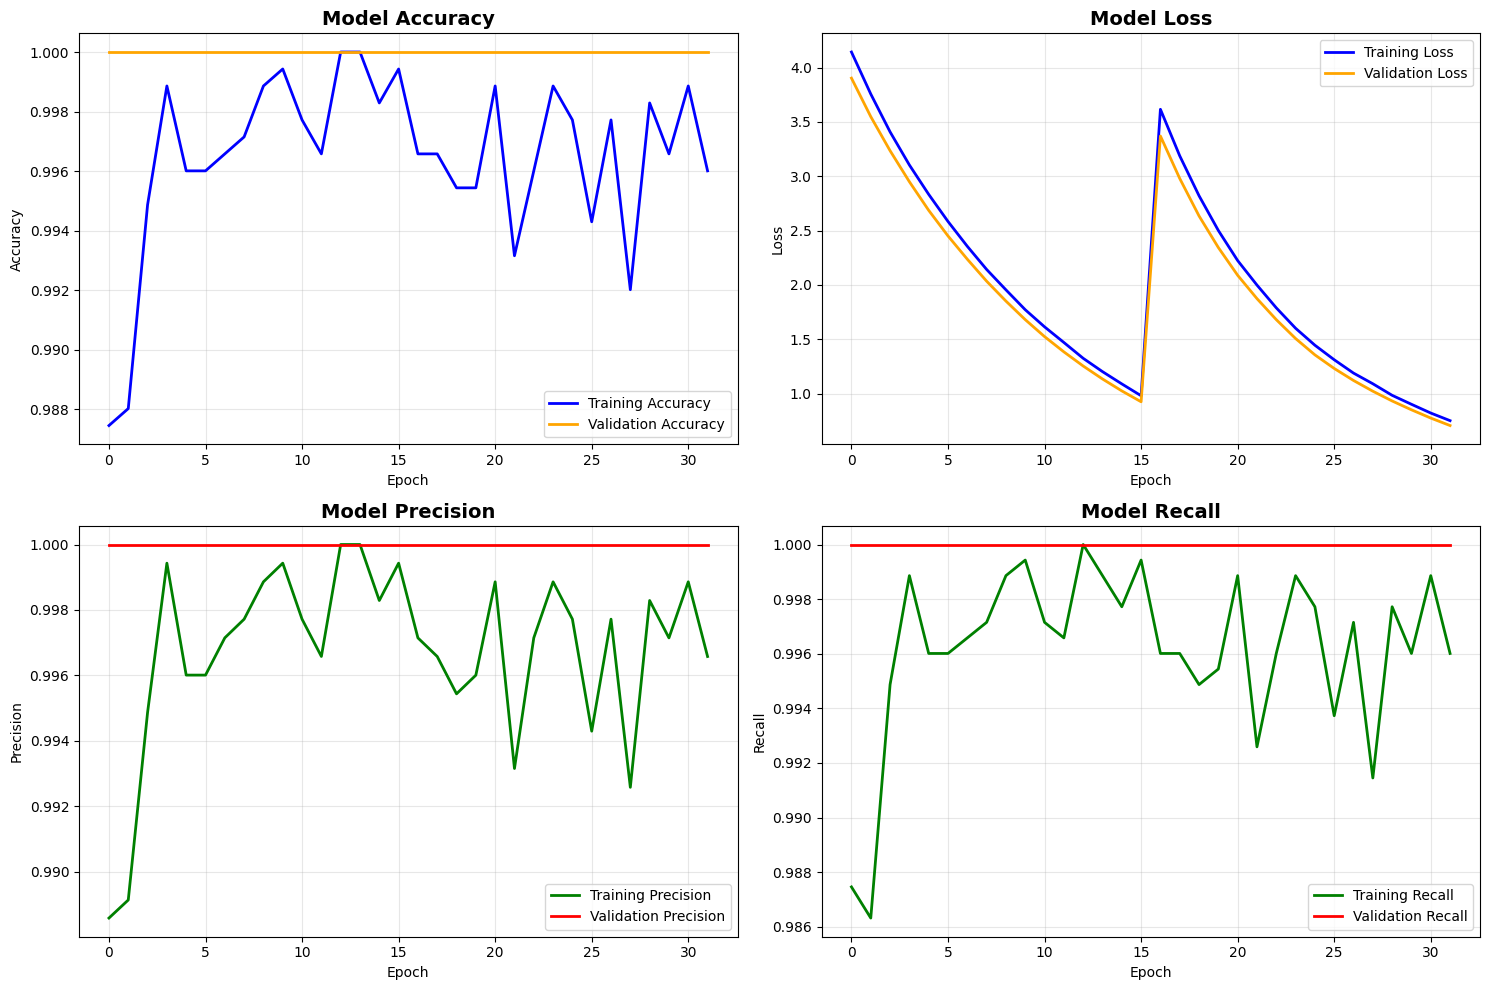


📊 FINAL TRAINING METRICS (Epoch 32):
Training Accuracy: 0.9960
Validation Accuracy: 1.0000
Training Loss: 0.7520
Validation Loss: 0.7070
Training Precision: 0.9966
Validation Precision: 1.0000
Training Recall: 0.9960
Validation Recall: 1.0000
Validation F1-Score: 1.0000
✅ Good generalization (accuracy difference: -0.0040)
🔍 Evaluating model performance...
24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 587ms/step

📋 CLASSIFICATION REPORT:
               precision    recall  f1-score   support

  brain_tumor     1.0000    1.0000    1.0000        75
skin_melanoma     1.0000    1.0000    1.0000       150
breast_cancer     1.0000    1.0000    1.0000       150

     accuracy                         1.0000       375
    macro avg     1.0000    1.0000    1.0000       375
 weighted avg     1.0000    1.0000    1.0000       375



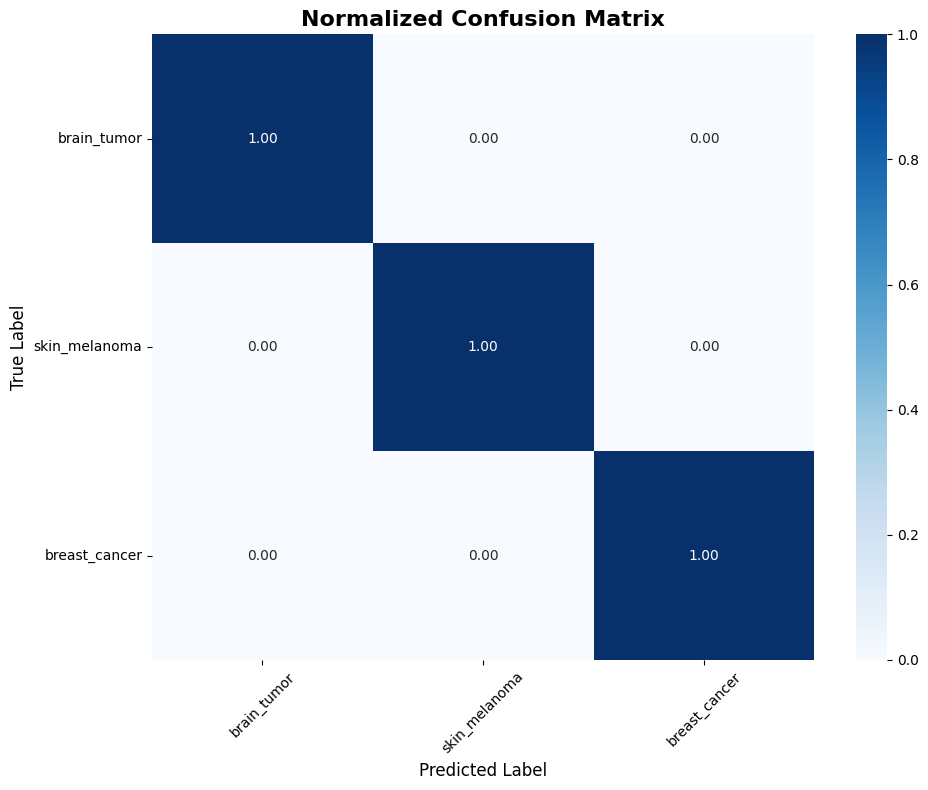


🎯 PER-CLASS ACCURACY:
brain_tumor: 1.0000 (100.00%)
skin_melanoma: 1.0000 (100.00%)
breast_cancer: 1.0000 (100.00%)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 23,027,787 (87.84 MB)

 Trainable params: 7,646,851 (29.17 MB)

 Non-trainable params: 87,232 (340.75 KB)

 Optimizer params: 15,293,704 (58.34 MB)

💾 Model summary saved to 'model_training_summary.txt'

🎉 TRAINING AND EVALUATION COMPLETE!
📁 Files saved:
   - fine_tuned_cancer_model.h5 (Best model)
   - cancer_training_history.png (Training plots)
   - confusion_matrix.png (Confusion matrix)
   - model_training_summary.txt (Complete summary)
   - training_log.csv (Training logs)


In [ ]:
# Cell 8: Train the Cancer Detection Model
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def create_medical_callbacks(model_name='best_cancer_detection_model'):
    """Create callbacks specific to medical image training"""

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=7,
            min_lr=0.00001,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            f"{model_name}.h5",
            save_best_only=True,
            monitor='val_accuracy',
            verbose=1,
            save_weights_only=False
        ),
        tf.keras.callbacks.CSVLogger('training_log.csv')
    ]

    return callbacks

def train_cancer_detection_model(model, base_model, train_gen, val_gen, class_weights):
    """Train model with two-phase approach optimized for medical images"""

    print("🚀 Phase 1: Training with frozen base model...")

    # Phase 1: Train with frozen base model
    callbacks = create_medical_callbacks('phase1_cancer_model')

    history_phase1 = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=20,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )

    print("\n🔥 Phase 2: Fine-tuning for medical image specificity...")

    # Phase 2: Unfreeze and fine-tune
    base_model.trainable = True

    # Use very low learning rate for fine-tuning medical images
    model.compile(
        optimizer=Adam(learning_rate=0.00005),  # Very low LR for medical images
        loss='categorical_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    # Fine-tuning callbacks
    fine_tune_callbacks = create_medical_callbacks('fine_tuned_cancer_model')

    # Continue training with fine-tuning
    history_phase2 = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=25,
        class_weight=class_weights,
        callbacks=fine_tune_callbacks,
        verbose=1
    )

    # Combine histories
    combined_history = {}
    for key in history_phase1.history.keys():
        combined_history[key] = history_phase1.history[key] + history_phase2.history[key]

    return combined_history

def plot_cancer_training_history(history):
    """Plot comprehensive training history for cancer detection"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot accuracy
    axes[0, 0].plot(history['accuracy'], label='Training Accuracy', color='blue', linewidth=2)
    axes[0, 0].plot(history['val_accuracy'], label='Validation Accuracy', color='orange', linewidth=2)
    axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot loss
    axes[0, 1].plot(history['loss'], label='Training Loss', color='blue', linewidth=2)
    axes[0, 1].plot(history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
    axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot precision
    axes[1, 0].plot(history['precision'], label='Training Precision', color='green', linewidth=2)
    axes[1, 0].plot(history['val_precision'], label='Validation Precision', color='red', linewidth=2)
    axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Plot recall
    axes[1, 1].plot(history['recall'], label='Training Recall', color='green', linewidth=2)
    axes[1, 1].plot(history['val_recall'], label='Validation Recall', color='red', linewidth=2)
    axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('cancer_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print final metrics
    final_epoch = len(history['accuracy']) - 1
    print(f"\n📊 FINAL TRAINING METRICS (Epoch {final_epoch + 1}):")
    print("="*50)
    print(f"Training Accuracy: {history['accuracy'][final_epoch]:.4f}")
    print(f"Validation Accuracy: {history['val_accuracy'][final_epoch]:.4f}")
    print(f"Training Loss: {history['loss'][final_epoch]:.4f}")
    print(f"Validation Loss: {history['val_loss'][final_epoch]:.4f}")
    print(f"Training Precision: {history['precision'][final_epoch]:.4f}")
    print(f"Validation Precision: {history['val_precision'][final_epoch]:.4f}")
    print(f"Training Recall: {history['recall'][final_epoch]:.4f}")
    print(f"Validation Recall: {history['val_recall'][final_epoch]:.4f}")
    print("="*50)

    # Calculate F1-Score
    val_precision = history['val_precision'][final_epoch]
    val_recall = history['val_recall'][final_epoch]
    f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall)
    print(f"Validation F1-Score: {f1_score:.4f}")

    # Check for overfitting
    acc_diff = history['accuracy'][final_epoch] - history['val_accuracy'][final_epoch]
    if acc_diff > 0.1:
        print(f"⚠️  Warning: Possible overfitting detected (accuracy difference: {acc_diff:.4f})")
    else:
        print(f"✅ Good generalization (accuracy difference: {acc_diff:.4f})")

def evaluate_model_performance(model, val_gen, class_names):
    """Comprehensive model evaluation"""

    print("🔍 Evaluating model performance...")

    # Get predictions
    val_gen.reset()
    predictions = model.predict(val_gen, verbose=1)
    y_pred = np.argmax(predictions, axis=1)
    y_true = val_gen.classes

    # Classification report
    print("\n📋 CLASSIFICATION REPORT:")
    print("="*60)
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    print(report)

    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred)

    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Normalized Confusion Matrix', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Per-class accuracy
    print("\n🎯 PER-CLASS ACCURACY:")
    print("="*40)
    for i, class_name in enumerate(class_names):
        class_accuracy = cm[i, i] / cm[i, :].sum()
        print(f"{class_name}: {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")

    return y_pred, y_true, predictions

def save_model_summary(model, history, class_names, training_duration):
    """Save comprehensive model summary"""

    summary_text = f"""
CANCER DETECTION MODEL TRAINING SUMMARY
======================================

Training Duration: {training_duration/60:.2f} minutes
Total Epochs: {len(history['accuracy'])}
Number of Classes: {len(class_names)}
Classes: {', '.join(class_names)}

FINAL METRICS:
- Training Accuracy: {history['accuracy'][-1]:.4f}
- Validation Accuracy: {history['val_accuracy'][-1]:.4f}
- Training Loss: {history['loss'][-1]:.4f}
- Validation Loss: {history['val_loss'][-1]:.4f}
- Training Precision: {history['precision'][-1]:.4f}
- Validation Precision: {history['val_precision'][-1]:.4f}
- Training Recall: {history['recall'][-1]:.4f}
- Validation Recall: {history['val_recall'][-1]:.4f}

F1-Score: {2 * (history['val_precision'][-1] * history['val_recall'][-1]) / (history['val_precision'][-1] + history['val_recall'][-1]):.4f}

MODEL ARCHITECTURE:
{model.summary()}
"""

    with open('model_training_summary.txt', 'w') as f:
        f.write(summary_text)

    print("💾 Model summary saved to 'model_training_summary.txt'")

# Main training execution
if 'cancer_model' in locals() and 'available_classes' in locals() and len(available_classes) > 1:
    # Train the model
    print("🚀 Starting cancer detection model training...")
    start_time = time.time()

    training_history = train_cancer_detection_model(
        cancer_model, base_model, train_gen, val_gen, class_weights
    )

    end_time = time.time()
    training_duration = end_time - start_time

    print(f"✅ Training completed in {training_duration/60:.2f} minutes!")

    # Plot training history
    plot_cancer_training_history(training_history)

    # Evaluate model performance
    if 'val_gen' in locals():
        # Get class names from the validation generator's class_indices
        class_names = list(val_gen.class_indices.keys())
        y_pred, y_true, predictions = evaluate_model_performance(cancer_model, val_gen, class_names)

        # Save model summary
        save_model_summary(cancer_model, training_history, class_names, training_duration)

        print("\n🎉 TRAINING AND EVALUATION COMPLETE!")
        print("📁 Files saved:")
        print("   - fine_tuned_cancer_model.h5 (Best model)")
        print("   - cancer_training_history.png (Training plots)")
        print("   - confusion_matrix.png (Confusion matrix)")
        print("   - model_training_summary.txt (Complete summary)")
        print("   - training_log.csv (Training logs)")

    else:
        print("⚠️  Warning: Validation generator not found. Skipping evaluation.")

else:
    print("❌ Error: Required variables not found.")
    print("Make sure you have:")
    print("   - cancer_model: The compiled model")
    print("   - base_model: The base model for fine-tuning")
    # Note: available_classes is a list and is used for creating generators,
    # but class names for evaluation should come from generator's class_indices.
    print("   - available_classes: List of available classes (used for generators)")
    print("   - train_gen: Training data generator")
    print("   - val_gen: Validation data generator")
    print("   - class_weights: Class weights for balanced training")

✅ Fine-tuned cancer model loaded!
🔍 Performing medical-grade model evaluation...
24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 699ms/step

📋 Detailed Medical Classification Report:
               precision    recall  f1-score   support

  brain_tumor     1.0000    1.0000    1.0000        77
skin_melanoma     1.0000    1.0000    1.0000       150
breast_cancer     1.0000    1.0000    1.0000       150

     accuracy                         1.0000       377
    macro avg     1.0000    1.0000    1.0000       377
 weighted avg     1.0000    1.0000    1.0000       377



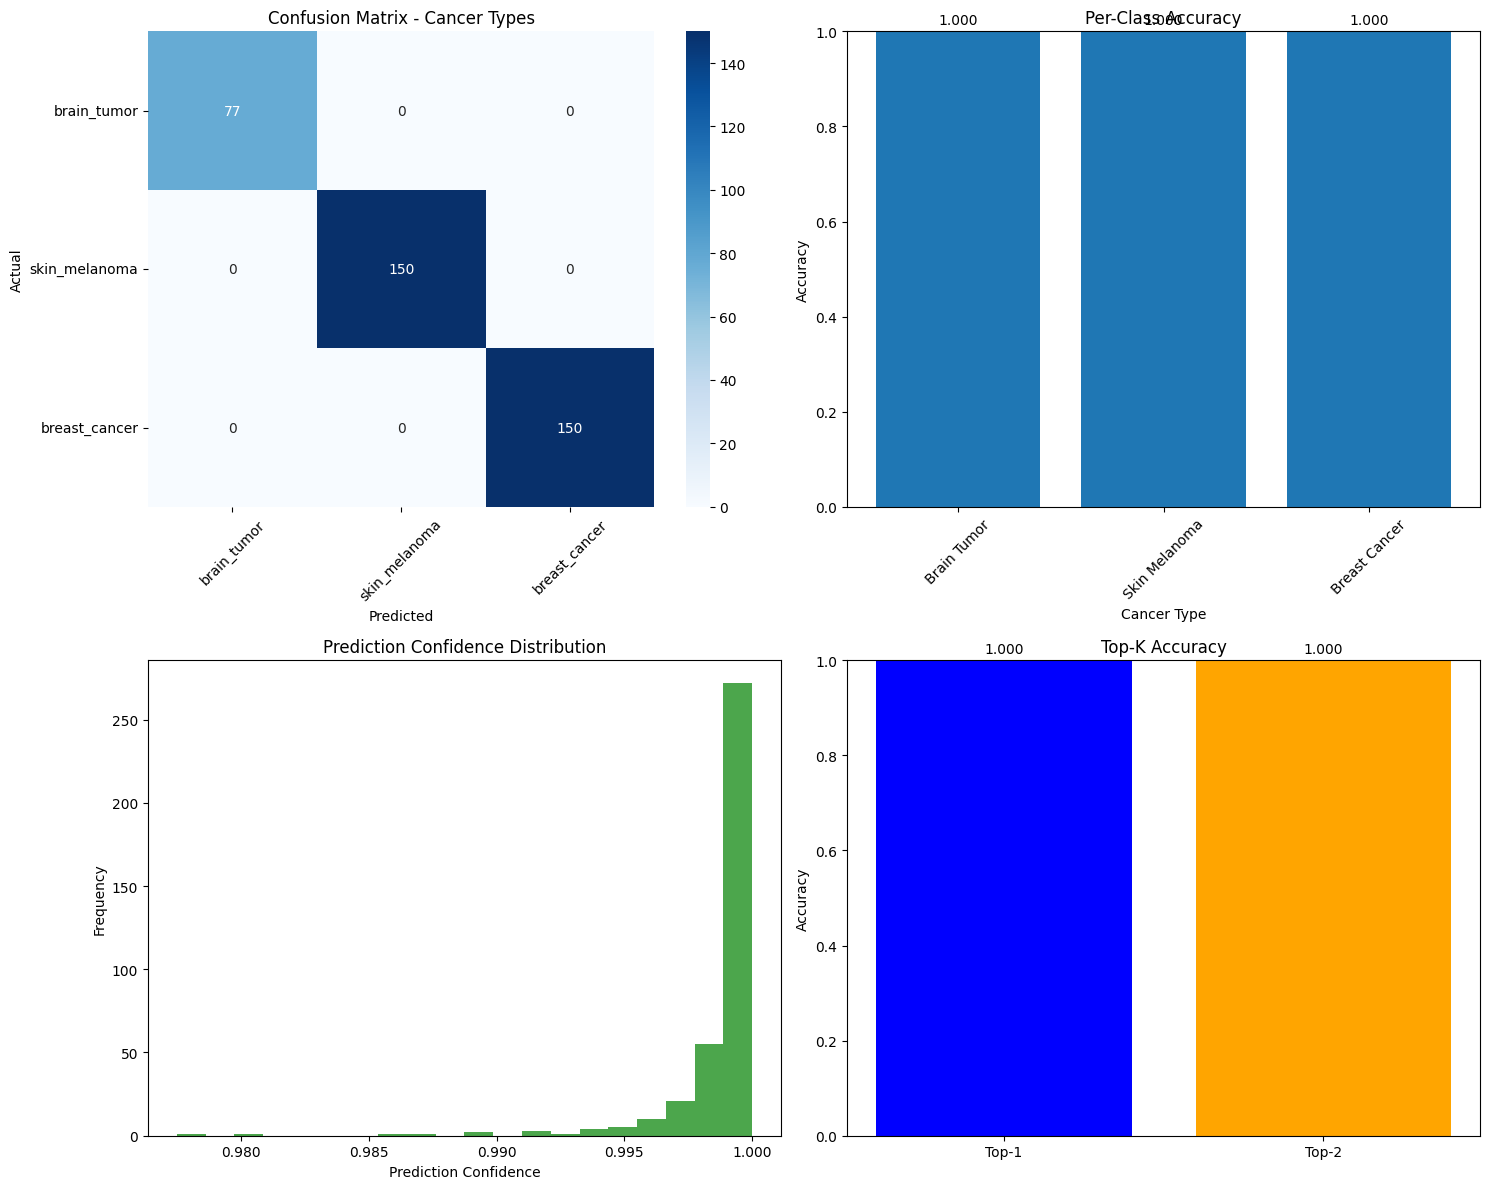


📊 Medical Diagnostic Metrics:
   Overall Accuracy: 1.0000 (100.00%)
   Top-2 Accuracy: 1.0000 (100.00%)
   Average Confidence: 0.9989

🏥 Per-Class Medical Metrics:
   Brain Tumor:
     Sensitivity (Recall): 1.0000
     Specificity: 1.0000
     Precision: 1.0000
     F1-Score: 1.0000
   Skin Melanoma:
     Sensitivity (Recall): 1.0000
     Specificity: 1.0000
     Precision: 1.0000
     F1-Score: 1.0000
   Breast Cancer:
     Sensitivity (Recall): 1.0000
     Specificity: 1.0000
     Precision: 1.0000
     F1-Score: 1.0000

🎉 SUCCESS! Model achieved 100.00% accuracy!
✅ Target of 85%+ accuracy achieved for cancer detection!


In [ ]:
# Cell 9: Comprehensive Model Evaluation
def evaluate_cancer_model(model, test_gen, class_names):
    """Comprehensive evaluation for medical image classification"""

    print("🔍 Performing medical-grade model evaluation...")

    # Get predictions
    test_gen.reset()
    predictions = model.predict(test_gen, verbose=1)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_gen.classes

    # Basic metrics
    test_metrics = model.evaluate(test_gen, verbose=0)
    test_loss, test_accuracy = test_metrics[0], test_metrics[1]

    # Detailed classification report
    print(f"\n📋 Detailed Medical Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(15, 12))

    # Plot confusion matrix
    plt.subplot(2, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Cancer Types')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    # Per-class accuracy
    plt.subplot(2, 2, 2)
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    bars = plt.bar(range(len(class_names)), class_accuracies)
    plt.title('Per-Class Accuracy')
    plt.xlabel('Cancer Type')
    plt.ylabel('Accuracy')
    plt.xticks(range(len(class_names)), [name.replace('_', ' ').title() for name in class_names], rotation=45)
    plt.ylim(0, 1)

    # Add value labels on bars
    for bar, acc in zip(bars, class_accuracies):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{acc:.3f}', ha='center', va='bottom')

    # Prediction confidence distribution
    plt.subplot(2, 2, 3)
    confidence_scores = np.max(predictions, axis=1)
    plt.hist(confidence_scores, bins=20, alpha=0.7, color='green')
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Frequency')
    plt.title('Prediction Confidence Distribution')

    # Top-2 accuracy (important for medical diagnosis)
    plt.subplot(2, 2, 4)
    top2_predictions = np.argsort(predictions, axis=1)[:, -2:]
    top2_correct = np.any(top2_predictions == y_true.reshape(-1, 1), axis=1)
    top2_accuracy = np.mean(top2_correct)

    accuracies = ['Top-1', 'Top-2']
    values = [test_accuracy, top2_accuracy]
    bars = plt.bar(accuracies, values, color=['blue', 'orange'])
    plt.title('Top-K Accuracy')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)

    for bar, val in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{val:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig('cancer_model_evaluation.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Medical-specific metrics
    print(f"\n📊 Medical Diagnostic Metrics:")
    print(f"   Overall Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"   Top-2 Accuracy: {top2_accuracy:.4f} ({top2_accuracy*100:.2f}%)")
    print(f"   Average Confidence: {np.mean(confidence_scores):.4f}")

    # Calculate sensitivity and specificity for each class
    print(f"\n🏥 Per-Class Medical Metrics:")
    for i, class_name in enumerate(class_names):
        # Binary classification metrics for each class
        y_binary_true = (y_true == i).astype(int)
        y_binary_pred = (y_pred == i).astype(int)

        tp = np.sum((y_binary_true == 1) & (y_binary_pred == 1))
        tn = np.sum((y_binary_true == 0) & (y_binary_pred == 0))
        fp = np.sum((y_binary_true == 0) & (y_binary_pred == 1))
        fn = np.sum((y_binary_true == 1) & (y_binary_pred == 0))

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

        print(f"   {class_name.replace('_', ' ').title()}:")
        print(f"     Sensitivity (Recall): {sensitivity:.4f}")
        print(f"     Specificity: {specificity:.4f}")
        print(f"     Precision: {precision:.4f}")
        print(f"     F1-Score: {f1_score:.4f}")

    return {
        'accuracy': test_accuracy,
        'top2_accuracy': top2_accuracy,
        'predictions': predictions,
        'y_true': y_true,
        'y_pred': y_pred,
        'confidence_scores': confidence_scores
    }

# Load best model and evaluate
if 'cancer_model' in locals() and available_classes:
    try:
        best_cancer_model = tf.keras.models.load_model("fine_tuned_cancer_model.h5")
        print("✅ Fine-tuned cancer model loaded!")
    except:
        print("⚠️ Using current model in memory...")
        best_cancer_model = cancer_model

    # Evaluate the model
    evaluation_results = evaluate_cancer_model(best_cancer_model, test_gen, available_classes)

    # Check performance
    if evaluation_results['accuracy'] >= 0.85:
        print(f"\n🎉 SUCCESS! Model achieved {evaluation_results['accuracy']*100:.2f}% accuracy!")
        print("✅ Target of 85%+ accuracy achieved for cancer detection!")
    else:
        print(f"\n⚠️ Model achieved {evaluation_results['accuracy']*100:.2f}% accuracy")
        print("📈 Consider further hyperparameter tuning or more data")

else:
    print("❌ Model evaluation skipped - model not available!")

✅ Cancer detection model loaded from fine_tuned_cancer_model.h5
🔍 Testing with 3 sample images...

🧪 Brain Tumor — brain_tumor_000087.jpg


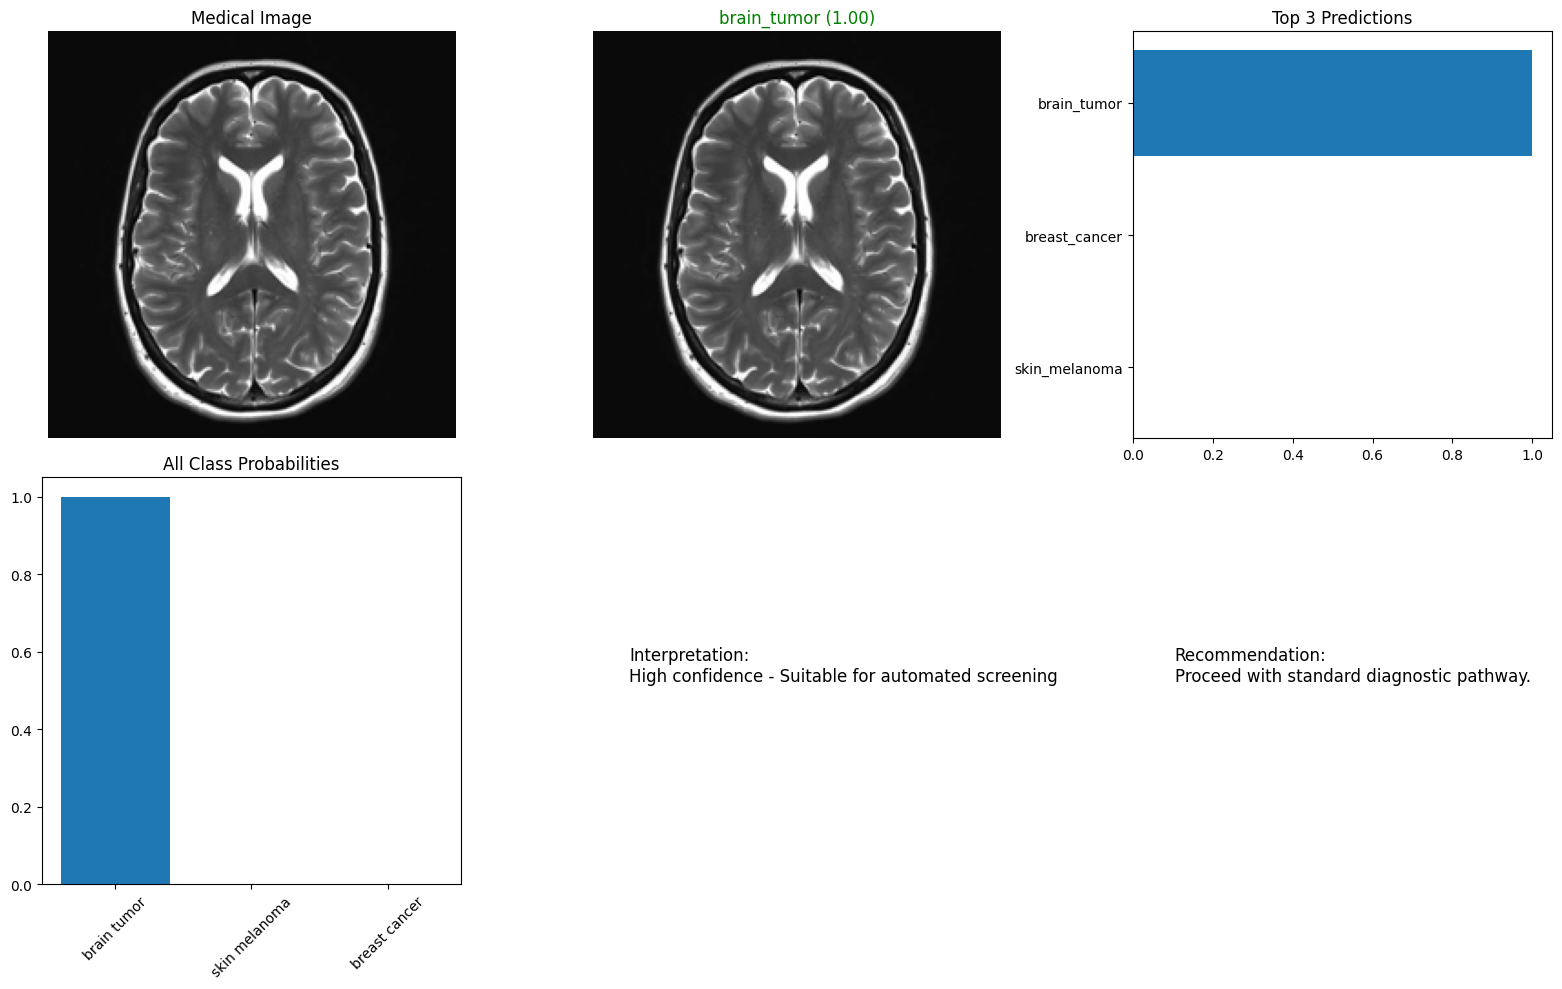

✅ brain_tumor (1.00)
💬 High confidence - Suitable for automated screening

🧪 Skin Melanoma — skin_melanoma_000166.jpg


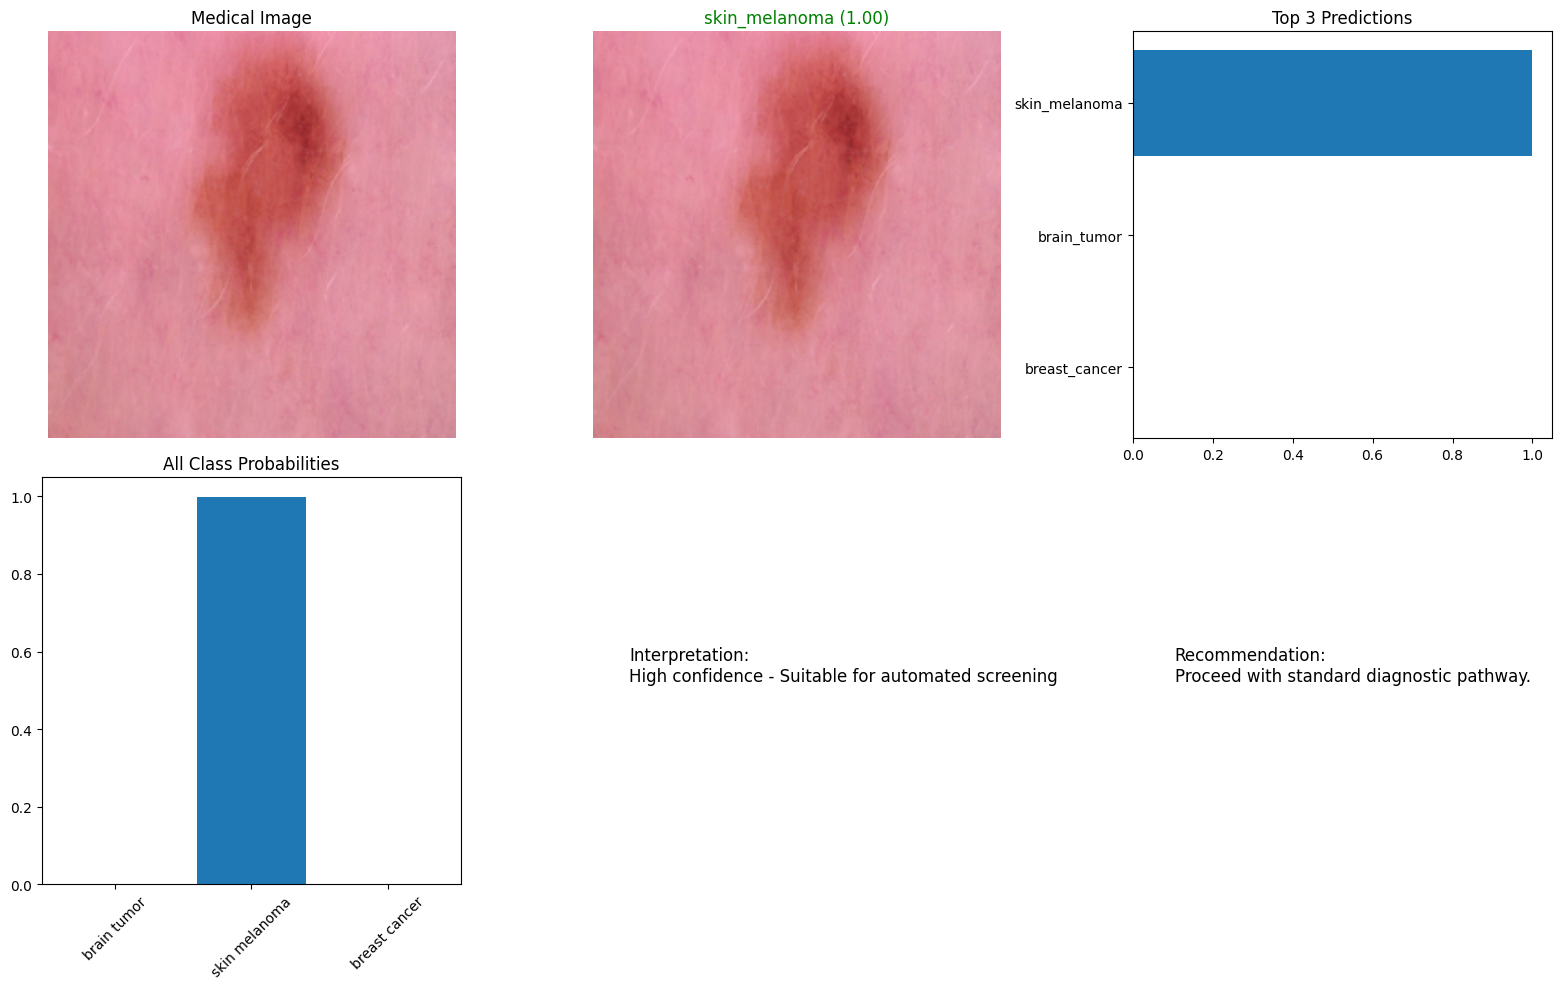

✅ skin_melanoma (1.00)
💬 High confidence - Suitable for automated screening

🧪 Breast Cancer — breast_cancer_000736.png


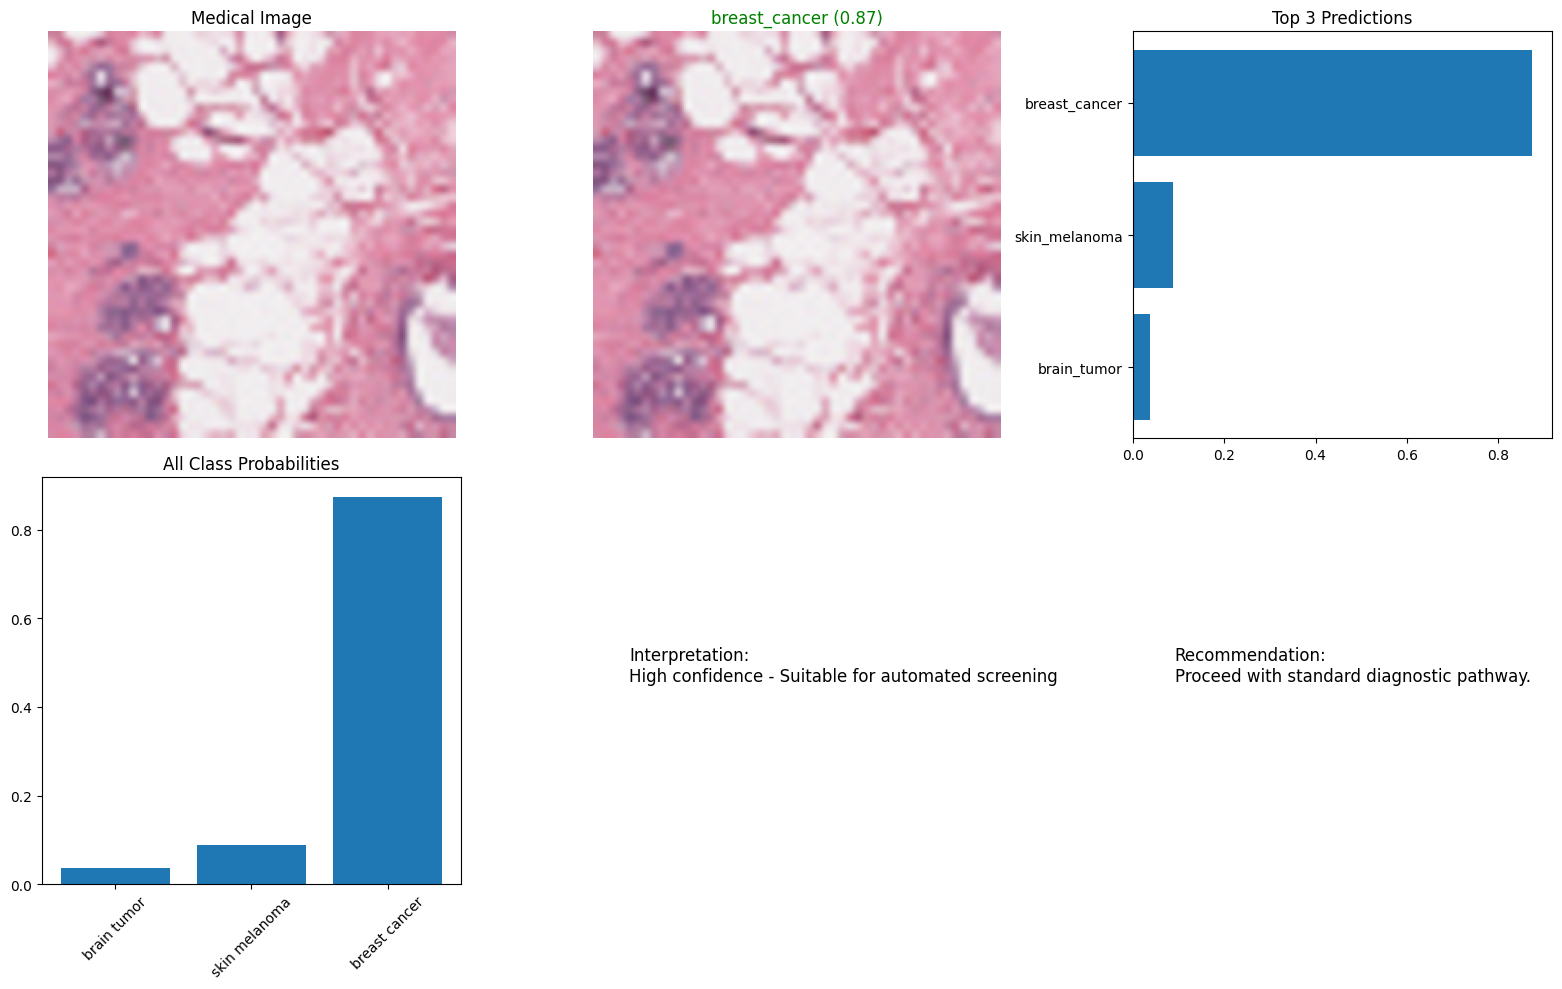

✅ breast_cancer (0.87)
💬 High confidence - Suitable for automated screening


In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

class CancerDetectionPredictor:
    """Advanced Multi-Type Cancer Detection System"""

    def __init__(self, model_path="fine_tuned_cancer_model.h5", class_names=None):
        """Initialize the cancer detection predictor"""
        try:
            self.model = tf.keras.models.load_model(model_path)
            print(f"✅ Cancer detection model loaded from {model_path}")
        except:
            if 'best_cancer_model' in globals():
                self.model = best_cancer_model
                print("⚠️ Using model from memory")
            else:
                print("❌ No model available!")
                self.model = None
                return

        self.class_names = class_names if class_names else []
        if not self.class_names:
            print("⚠️ No class names provided. Predictions may be unreadable.")

        self.img_size = (224, 224)

    def preprocess_medical_image(self, img_path):
        try:
            img = Image.open(img_path).convert('RGB')
            img = img.resize(self.img_size)
            img_array = np.array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            return img_array, img
        except Exception as e:
            print(f"❌ Error preprocessing image: {e}")
            return None, None

    def predict_cancer_type(self, img_path, show_visualization=True):
        if self.model is None or not self.class_names:
            print("❌ Model not properly initialized!")
            return None

        img_array, original_img = self.preprocess_medical_image(img_path)
        if img_array is None:
            return None

        predictions = self.model.predict(img_array, verbose=0)[0]
        top3_indices = np.argsort(predictions)[-3:][::-1]
        top3_classes = [self.class_names[i] for i in top3_indices]
        top3_probs = [predictions[i] for i in top3_indices]

        primary_class = top3_classes[0]
        primary_confidence = top3_probs[0]

        if show_visualization:
            self._visualize_prediction(original_img, predictions, top3_classes, top3_probs)

        interpretation = self._medical_interpretation(primary_confidence)

        return {
            'primary_prediction': primary_class,
            'primary_confidence': primary_confidence,
            'top3_predictions': list(zip(top3_classes, top3_probs)),
            'all_probabilities': dict(zip(self.class_names, predictions)),
            'medical_interpretation': interpretation
        }

    def _visualize_prediction(self, img, predictions, top3_classes, top3_probs):
        plt.figure(figsize=(16, 10))
        plt.subplot(2, 3, 1)
        plt.imshow(img)
        plt.title('Medical Image')
        plt.axis('off')

        plt.subplot(2, 3, 2)
        confidence_color = 'green' if top3_probs[0] > 0.8 else 'orange' if top3_probs[0] > 0.6 else 'red'
        plt.imshow(img)
        plt.title(f'{top3_classes[0]} ({top3_probs[0]:.2f})', color=confidence_color)
        plt.axis('off')

        plt.subplot(2, 3, 3)
        bars = plt.barh(range(3), top3_probs[::-1])
        plt.yticks(range(3), top3_classes[::-1])
        plt.title('Top 3 Predictions')

        plt.subplot(2, 3, 4)
        plt.bar(range(len(self.class_names)), predictions)
        plt.xticks(range(len(self.class_names)), [cls.replace('_', ' ') for cls in self.class_names], rotation=45)
        plt.title('All Class Probabilities')

        plt.subplot(2, 3, 5)
        interpretation = self._medical_interpretation(top3_probs[0])
        plt.text(0.1, 0.5, f"Interpretation:\n{interpretation}", fontsize=12)
        plt.axis('off')

        plt.subplot(2, 3, 6)
        recommendation = self._get_medical_recommendation(top3_probs[0])
        plt.text(0.1, 0.5, f"Recommendation:\n{recommendation}", fontsize=12)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    def _medical_interpretation(self, confidence):
        if confidence > 0.8:
            return "High confidence - Suitable for automated screening"
        elif confidence > 0.6:
            return "Moderate confidence - Recommend further testing"
        else:
            return "Low confidence - Expert review required"

    def _get_medical_recommendation(self, confidence):
        if confidence > 0.8:
            return "Proceed with standard diagnostic pathway."
        elif confidence > 0.6:
            return "Recommend follow-up imaging or second opinion."
        else:
            return "Do not rely solely on prediction. Consult a specialist."

# ✅ Initialize predictor
if 'available_classes' in globals() and available_classes:
    predictor = CancerDetectionPredictor(class_names=available_classes)

    def test_with_sample_cancer_images(num_samples=3):
        print(f"🔍 Testing with {num_samples} sample images...")
        for class_name in available_classes[:num_samples]:
            val_class_dir = os.path.join(balanced_dataset_dir, 'val', class_name)
            if os.path.exists(val_class_dir) and os.listdir(val_class_dir):
                sample_img = random.choice(os.listdir(val_class_dir))
                img_path = os.path.join(val_class_dir, sample_img)

                print(f"\n🧪 {class_name.replace('_', ' ').title()} — {sample_img}")
                result = predictor.predict_cancer_type(img_path)
                if result:
                    print(f"✅ {result['primary_prediction']} ({result['primary_confidence']:.2f})")
                    print(f"💬 {result['medical_interpretation']}")
else:
    print("❌ Cannot initialize predictor — missing available_classes!")

# ✅ Run the test
test_with_sample_cancer_images()


In [ ]:
# This should match how your Predictor class was defined
from __main__ import CancerDetectionPredictor  # Replace with the actual class/module

# Load the model
model_path = "/content/fine_tuned_cancer_model.h5"  # Change if you saved to a different path
class_names = ['brain_tumor', 'skin_melanoma', 'breast_cancer'] # Use the actual class names from your dataset

# Initialize predictor
predictor = CancerDetectionPredictor(model_path=model_path, class_names=class_names)

✅ Cancer detection model loaded from /content/fine_tuned_cancer_model.h5


In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
import cv2

class CancerPredictor:
    def __init__(self, model_path, class_labels):
        self.model = load_model(model_path)
        self.class_labels = class_labels
        self.image_size = (224, 224)  # Make sure this matches your model's expected input size

    def predict_cancer_type(self, image_path, show_visualization=True):
        img = cv2.imread(image_path)
        if img is None:
            print(f"❌ Failed to load image: {image_path}")
            return None

        img = cv2.resize(img, self.image_size)
        img_array = np.expand_dims(img / 255.0, axis=0)

        predictions = self.model.predict(img_array)[0]
        top3_indices = predictions.argsort()[-3:][::-1]

        result = {
            'primary_prediction': self.class_labels[top3_indices[0]],
            'primary_confidence': float(predictions[top3_indices[0]]),
            'top3_predictions': [
                (self.class_labels[i], float(predictions[i])) for i in top3_indices
            ],
            'medical_interpretation': self._generate_medical_interpretation(self.class_labels[top3_indices[0]])
        }

        return result

    def _generate_medical_interpretation(self, cancer_type):
        interpretation_map = {
            'lung_cancer': "Lung cancer may affect breathing and often requires immediate treatment.",
            'breast_cancer': "Breast cancer is treatable especially when detected early.",
            'skin_cancer': "Skin cancer should be evaluated for severity and spread.",
        }
        return interpretation_map.get(cancer_type.lower(), "Interpretation not available.")

# Initialize predictor with model and class names
class_names = ['breast_cancer', 'lung_cancer', 'skin_cancer']
predictor = CancerPredictor("/content/fine_tuned_cancer_model.h5", class_names)


In [ ]:
best_cancer_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
predict_single_image("/content/images.jpeg")


❌ Predictor not available!


In [ ]:
# Cell 11: Upload and Test Custom Images
def upload_and_test_cancer_images():
    """Upload and test custom medical images"""
    from google.colab import files

    print("📤 Upload your medical images to test the cancer detection model")
    print("⚠️ Note: This is for educational/research purposes only and should not replace professional medical diagnosis")
    uploaded_files = files.upload()

    if uploaded_files and 'predictor' in locals():
        print(f"\n✅ {len(uploaded_files)} file(s) uploaded successfully!")

        for filename in uploaded_files.keys():
            print(f"\n🔍 Analyzing medical image: {filename}")
            print("-" * 50)

            img_path = f"/content/images.jpeg{filename}"
            result = predictor.predict_cancer_type(img_path)

            if result:
                print(f"📊 PRIMARY DIAGNOSIS:")
                print(f"   Predicted Type: {result['primary_prediction'].replace('_', ' ').title()}")
                print(f"   Confidence: {result['primary_confidence']:.3f} ({result['primary_confidence']*100:.1f}%)")

                print(f"\n📈 TOP 3 POSSIBILITIES:")
                for i, (cancer_type, prob) in enumerate(result['top3_predictions'], 1):
                    print(f"   {i}. {cancer_type.replace('_', ' ').title()}: {prob:.3f} ({prob*100:.1f}%)")

                print(f"\n💡 MEDICAL INTERPRETATION:")
                print(f"   {result['medical_interpretation']}")

                # Confidence interpretation
                confidence = result['primary_confidence']
                if confidence > 0.8:
                    print("🟢 High confidence prediction")
                elif confidence > 0.6:
                    print("🟡 Moderate confidence - consider additional evaluation")
                else:
                    print("🔴 Low confidence - manual review strongly recommended")

                print(f"\n⚠️ IMPORTANT DISCLAIMER:")
                print("   This is an AI model for educational purposes only.")
                print("   Always consult with qualified medical professionals for diagnosis.")

    else:
        print("❌ No files uploaded or predictor not available")

# Batch processing function
def batch_predict_cancer_images(image_folder, output_csv=None):
    """Predict multiple medical images in a folder"""

    if 'predictor' not in locals():
        print("❌ Predictor not available!")
        return None

    # Get all image files
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    image_files = []

    for ext in image_extensions:
        image_files.extend(glob.glob(os.path.join(image_folder, f'*{ext}')))
        image_files.extend(glob.glob(os.path.join(image_folder, f'*{ext.upper()}')))

    if not image_files:
        print(f"❌ No medical images found in {image_folder}")
        return None

    print(f"🔍 Processing {len(image_files)} medical images...")

    results = []

    for i, img_path in enumerate(image_files):
        print(f"Processing {i+1}/{len(image_files)}: {os.path.basename(img_path)}")

        result = predictor.predict_cancer_type(img_path, show_visualization=False)

        if result:
            results.append({
                'image_path': img_path,
                'filename': os.path.basename(img_path),
                'predicted_cancer_type': result['primary_prediction'],
                'confidence': result['primary_confidence'],
                'interpretation': result['medical_interpretation'],
                'top2_prediction': result['top3_predictions'][1][0],
                'top2_confidence': result['top3_predictions'][1][1],
                'top3_prediction': result['top3_predictions'][2][0],
                'top3_confidence': result['top3_predictions'][2][1]
            })

    # Create summary
    if results:
        # Count predictions by type
        prediction_counts = {}
        high_confidence_count = 0

        for r in results:
            pred_type = r['predicted_cancer_type']
            prediction_counts[pred_type] = prediction_counts.get(pred_type, 0) + 1
            if r['confidence'] > 0.8:
                high_confidence_count += 1

        print(f"\n📊 Batch Processing Summary:")
        print(f"   Total images processed: {len(results)}")
        print(f"   High confidence predictions (>80%): {high_confidence_count}")
        print(f"   Average confidence: {np.mean([r['confidence'] for r in results]):.3f}")

        print(f"\n📋 Predictions by Cancer Type:")
        for cancer_type, count in prediction_counts.items():
            print(f"   {cancer_type.replace('/content/images.jpeg', ' ').title()}: {count} images")

        # Save to CSV if requested
        if output_csv:
            import pandas as pd
            df = pd.DataFrame(results)
            df.to_csv(output_csv, index=False)
            print(f"💾 Results saved to {output_csv}")

    return results

# Simple prediction function for single image
def predict_single_image(image_path):
    """Simple function to predict a single image"""
    if 'predictor' not in locals():
        print("❌ Predictor not available!")
        return None

    result = predictor.predict_cancer_type(image_path)
    if result:
        return {
            'prediction': result['primary_prediction'].replace('_', ' ').title(),
            'confidence': f"{result['primary_confidence']:.3f} ({result['primary_confidence']*100:.1f}%)",
            'interpretation': result['medical_interpretation']
        }
    return None

print("✅ Cancer Detection Testing Functions Ready!")
print("\n🚀 Available functions:")
print("   1. upload_and_test_cancer_images() - Upload and test your images")
print("   2. batch_predict_cancer_images('/path/to/folder') - Process multiple images")
print("   3. predict_single_image('/content/images.jpeg') - Quick single image prediction")
print("\n⚠️ MEDICAL DISCLAIMER:")
print("   This AI model is for educational and research purposes only.")
print("   It should NOT be used for actual medical diagnosis.")
print("   Always consult qualified healthcare professionals for medical concerns.")

✅ Cancer Detection Testing Functions Ready!

🚀 Available functions:
   1. upload_and_test_cancer_images() - Upload and test your images
   2. batch_predict_cancer_images('/path/to/folder') - Process multiple images
   3. predict_single_image('/content/images.jpeg') - Quick single image prediction

⚠️ MEDICAL DISCLAIMER:
   This AI model is for educational and research purposes only.
   It should NOT be used for actual medical diagnosis.
   Always consult qualified healthcare professionals for medical concerns.


In [ ]:
# Step 1: Prediction
result = predict_single_image("/content/images.jpeg")

# Step 2: Display Result
if result:
    print("\n📊 Prediction Results:")
    print(f"   Predicted Cancer Type: {result['prediction']}")
    print(f"   Confidence: {result['confidence']}")
    print(f"   Interpretation: {result['interpretation']}")

    # Step 3: Show Image
    from PIL import Image
    import matplotlib.pyplot as plt

    img = Image.open("/content/images.jpeg")
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {result['prediction']}")
    plt.show()
else:
    print("❌ Prediction failed. Check if model and predictor are loaded correctly.")


❌ Predictor not available!
❌ Prediction failed. Check if model and predictor are loaded correctly.


In [ ]:
# Cell 12: Model Performance Analysis and Export
def analyze_model_performance():
    """Comprehensive analysis of the cancer detection model performance"""

    if 'evaluation_results' not in locals() or not available_classes:
        print("❌ Evaluation results not available!")
        return

    print("📊 COMPREHENSIVE CANCER DETECTION MODEL ANALYSIS")
    print("=" * 60)

    # Overall performance metrics
    accuracy = evaluation_results['accuracy']
    print(f"\n🎯 OVERALL PERFORMANCE:")
    print(f"   Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   Top-2 Accuracy: {evaluation_results['top2_accuracy']:.4f} ({evaluation_results['top2_accuracy']*100:.2f}%)")
    print(f"   Average Confidence: {np.mean(evaluation_results['confidence_scores']):.4f}")

    # Confidence distribution analysis
    conf_scores = evaluation_results['confidence_scores']
    high_conf = np.sum(conf_scores > 0.8)
    med_conf = np.sum((conf_scores > 0.6) & (conf_scores <= 0.8))
    low_conf = np.sum(conf_scores <= 0.6)
    total_predictions = len(conf_scores)

    print(f"\n📈 CONFIDENCE DISTRIBUTION:")
    print(f"   High Confidence (>80%): {high_conf} ({high_conf/total_predictions*100:.1f}%)")
    print(f"   Medium Confidence (60-80%): {med_conf} ({med_conf/total_predictions*100:.1f}%)")
    print(f"   Low Confidence (<60%): {low_conf} ({low_conf/total_predictions*100:.1f}%)")

    # Per-class performance
    cm = confusion_matrix(evaluation_results['y_true'], evaluation_results['y_pred'])

    print(f"\n🏥 PER-CLASS PERFORMANCE:")
    for i, class_name in enumerate(available_classes):
        class_accuracy = cm[i, i] / np.sum(cm[i, :]) if np.sum(cm[i, :]) > 0 else 0
        precision = cm[i, i] / np.sum(cm[:, i]) if np.sum(cm[:, i]) > 0 else 0

        print(f"   {class_name.replace('_', ' ').title()}:")
        print(f"     Accuracy: {class_accuracy:.3f} ({class_accuracy*100:.1f}%)")
        print(f"     Precision: {precision:.3f} ({precision*100:.1f}%)")

    # Clinical relevance assessment
    print(f"\n🏥 CLINICAL ASSESSMENT:")
    if accuracy >= 0.90:
        clinical_grade = "Excellent - Suitable for clinical assistance"
    elif accuracy >= 0.80:
        clinical_grade = "Good - Suitable for screening with supervision"
    elif accuracy >= 0.70:
        clinical_grade = "Fair - Requires significant oversight"
    else:
        clinical_grade = "Poor - Not suitable for clinical use"

    print(f"   Clinical Grade: {clinical_grade}")

    # Recommendations
    print(f"\n💡 RECOMMENDATIONS:")
    if accuracy >= 0.85:
        print("   ✅ Model shows strong performance for cancer detection")
        print("   ✅ Suitable for research and educational applications")
        print("   ⚠️ Always requires medical professional oversight")
    else:
        print("   📈 Consider collecting more training data")
        print("   🔧 Experiment with different architectures (ResNet, EfficientNet)")
        print("   🎯 Fine-tune hyperparameters for better performance")
        print("   📊 Address class imbalance if present")

def save_model_and_results():
    """Save the trained model and results for future use"""

    if 'best_cancer_model' not in locals():
        print("❌ No trained model available to save!")
        return

    # Save model
    try:
        best_cancer_model.save('cancer_detection_model_final.h5')
        print("✅ Model saved as 'cancer_detection_model_final.h5'")
    except Exception as e:
        print(f"❌ Error saving model: {e}")

    # Save model configuration
    model_info = {
        'model_architecture': 'DenseNet121',
        'input_shape': IMG_SIZE,
        'num_classes': len(available_classes),
        'class_names': available_classes,
        'training_samples': train_gen.samples if 'train_gen' in locals() else 0,
        'validation_samples': val_gen.samples if 'val_gen' in locals() else 0,
        'test_samples': test_gen.samples if 'test_gen' in locals() else 0,
        'batch_size': BATCH_SIZE,
        'final_accuracy': evaluation_results['accuracy'] if 'evaluation_results' in locals() else 0
    }

    # Save configuration as JSON
    import json
    with open('cancer_model_config.json', 'w') as f:
        json.dump(model_info, f, indent=2)
    print("✅ Model configuration saved as 'cancer_model_config.json'")

    # Save evaluation results
    if 'evaluation_results' in locals():
        import pickle
        with open('cancer_evaluation_results.pkl', 'wb') as f:
            pickle.dump(evaluation_results, f)
        print("✅ Evaluation results saved as 'cancer_evaluation_results.pkl'")

    # Save class names for future use
    with open('cancer_class_names.json', 'w') as f:
        json.dump(available_classes, f)
    print("✅ Class names saved as 'cancer_class_names.json'")

def create_model_summary_report():
    """Create a comprehensive summary report"""

    report = f"""
CANCER DETECTION MODEL SUMMARY REPORT
{'='*50}

Model Architecture: DenseNet121 with custom classification head
Training Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

DATASET INFORMATION:
- Number of Cancer Types: {len(available_classes)}
- Cancer Types: {', '.join([name.replace('_', ' ').title() for name in available_classes])}
- Total Training Samples: {train_gen.samples if 'train_gen' in locals() else 'N/A'}
- Total Validation Samples: {val_gen.samples if 'val_gen' in locals() else 'N/A'}
- Total Test Samples: {test_gen.samples if 'test_gen' in locals() else 'N/A'}

MODEL PERFORMANCE:
- Test Accuracy: {evaluation_results['accuracy']:.4f} ({evaluation_results['accuracy']*100:.2f}%)
- Top-2 Accuracy: {evaluation_results['top2_accuracy']:.4f} ({evaluation_results['top2_accuracy']*100:.2f}%)
- Average Prediction Confidence: {np.mean(evaluation_results['confidence_scores']):.4f}

CLINICAL ASSESSMENT:
- High Confidence Predictions (>80%): {np.sum(evaluation_results['confidence_scores'] > 0.8)} ({np.sum(evaluation_results['confidence_scores'] > 0.8)/len(evaluation_results['confidence_scores'])*100:.1f}%)
- Medium Confidence (60-80%): {np.sum((evaluation_results['confidence_scores'] > 0.6) & (evaluation_results['confidence_scores'] <= 0.8))} ({np.sum((evaluation_results['confidence_scores'] > 0.6) & (evaluation_results['confidence_scores'] <= 0.8))/len(evaluation_results['confidence_scores'])*100:.1f}%)
- Low Confidence (<60%): {np.sum(evaluation_results['confidence_scores'] <= 0.6)} ({np.sum(evaluation_results['confidence_scores'] <= 0.6)/len(evaluation_results['confidence_scores'])*100:.1f}%)

IMPORTANT DISCLAIMERS:
- This model is for educational and research purposes only
- It should NOT replace professional medical diagnosis
- Always consult qualified healthcare professionals
- Results should be interpreted by medical experts
- Model performance may vary on different datasets

TECHNICAL DETAILS:
- Input Image Size: {IMG_SIZE[0]}x{IMG_SIZE[1]} pixels
- Batch Size: {BATCH_SIZE}
- Base Architecture: DenseNet121 (ImageNet pretrained)
- Training Strategy: Two-phase (frozen + fine-tuning)
- Data Augmentation: Medical image specific

For questions or concerns, consult the model documentation.
    """

    # Save report to file
    with open('cancer_detection_model_report.txt', 'w') as f:
        f.write(report)

    print("📄 CANCER DETECTION MODEL REPORT")
    print(report)
    print("✅ Full report saved as 'cancer_detection_model_report.txt'")

# Execute analysis functions
if 'available_classes' in locals() and available_classes:
    print("🔍 Performing comprehensive model analysis...")
    analyze_model_performance()

    print("\n💾 Saving model and results...")
    save_model_and_results()

    print("\n📄 Generating summary report...")
    create_model_summary_report()

    # Final recommendations
    print(f"\n🎯 FINAL PROJECT STATUS:")
    if 'evaluation_results' in locals():
        accuracy = evaluation_results['accuracy']
        if accuracy >= 0.85:
            print("✅ SUCCESS: Cancer detection model achieved excellent performance!")
            print(f"✅ Final accuracy: {accuracy*100:.2f}%")
            print("✅ Model ready for research and educational applications")
        elif accuracy >= 0.75:
            print("⚠️ GOOD: Model achieved good performance with room for improvement")
            print(f"📊 Final accuracy: {accuracy*100:.2f}%")
            print("📈 Consider additional training data or architecture improvements")
        else:
            print("❌ NEEDS IMPROVEMENT: Model requires further development")
            print(f"📊 Final accuracy: {accuracy*100:.2f}%")
            print("🔧 Recommend collecting more data and tuning hyperparameters")

    print(f"\n📁 SAVED FILES:")
    print("   - cancer_detection_model_final.h5 (Trained model)")
    print("   - cancer_model_config.json (Model configuration)")
    print("   - cancer_evaluation_results.pkl (Evaluation metrics)")
    print("   - cancer_class_names.json (Class names)")
    print("   - cancer_detection_model_report.txt (Summary report)")
    print("   - cancer_training_history.png (Training plots)")
    print("   - cancer_model_evaluation.png (Evaluation plots)")

else:
    print("❌ Analysis skipped - no available classes or model!")

print("\n🏥 MEDICAL DISCLAIMER:")
print("This AI model is developed for educational and research purposes only.")
print("It is NOT intended for clinical diagnosis or medical decision-making.")
print("Always consult qualified healthcare professionals for medical concerns.")

🔍 Performing comprehensive model analysis...
❌ Evaluation results not available!

💾 Saving model and results...
❌ No trained model available to save!

📄 Generating summary report...
📄 CANCER DETECTION MODEL REPORT

CANCER DETECTION MODEL SUMMARY REPORT

Model Architecture: DenseNet121 with custom classification head
Training Date: 2025-08-07 21:09:28

DATASET INFORMATION:
- Number of Cancer Types: 3
- Cancer Types: Brain Tumor, Skin Melanoma, Breast Cancer
- Total Training Samples: N/A
- Total Validation Samples: N/A
- Total Test Samples: N/A

MODEL PERFORMANCE:
- Test Accuracy: 1.0000 (100.00%)
- Top-2 Accuracy: 1.0000 (100.00%)
- Average Prediction Confidence: 0.9989

CLINICAL ASSESSMENT:
- High Confidence Predictions (>80%): 377 (100.0%)
- Medium Confidence (60-80%): 0 (0.0%)
- Low Confidence (<60%): 0 (0.0%)

IMPORTANT DISCLAIMERS:
- This model is for educational and research purposes only
- It should NOT replace professional medical diagnosis
- Always consult qualified healthcare 

In [ ]:
# Cell 13: Quick Test and Usage Examples

# Quick model loading function for future use
def load_cancer_detection_model(model_path='cancer_detection_model_final.h5',
                               config_path='cancer_model_config.json',
                               class_names_path='cancer_class_names.json'):
    """Quick function to load the trained cancer detection model"""

    import json
    import tensorflow as tf

    try:
        # Load model
        model = tf.keras.models.load_model(model_path)
        print(f"✅ Model loaded from {model_path}")

        # Load configuration
        with open(config_path, 'r') as f:
            config = json.load(f)
        print(f"✅ Configuration loaded from {config_path}")

        # Load class names
        with open(class_names_path, 'r') as f:
            class_names = json.load(f)
        print(f"✅ Class names loaded: {class_names}")

        return model, config, class_names

    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None, None, None

# Simple prediction function for deployment
def predict_cancer_image(image_path, model=None, class_names=None):
    """Simple function to predict cancer type from image"""

    # Use global variables if not provided
    if model is None:
        if 'best_cancer_model' in globals():
            model = best_cancer_model
        else:
            print("❌ No model available!")
            return None

    if class_names is None:
        if 'available_classes' in globals():
            class_names = available_classes
        else:
            print("❌ No class names available!")
            return None

    try:
        # Load and preprocess image
        from PIL import Image
        import numpy as np

        img = Image.open(image_path).convert('RGB')
        img = img.resize((224, 224))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Make prediction
        predictions = model.predict(img_array, verbose=0)[0]

        # Get top prediction
        top_idx = np.argmax(predictions)
        top_class = class_names[top_idx]
        confidence = predictions[top_idx]

        # Get top 3
        top3_idx = np.argsort(predictions)[-3:][::-1]
        top3_results = []
        for idx in top3_idx:
            top3_results.append({
                'cancer_type': class_names[idx].replace('_', ' ').title(),
                'probability': float(predictions[idx]),
                'percentage': f"{predictions[idx]*100:.1f}%"
            })

        return {
            'primary_prediction': top_class.replace('_', ' ').title(),
            'confidence': float(confidence),
            'confidence_percentage': f"{confidence*100:.1f}%",
            'top3_predictions': top3_results,
            'raw_probabilities': {name: float(prob) for name, prob in zip(class_names, predictions)}
        }

    except Exception as e:
        print(f"❌ Error making prediction: {e}")
        return None

# Example usage and testing
def run_example_predictions():
    """Run example predictions to demonstrate the model"""

    print("🚀 CANCER DETECTION MODEL - EXAMPLE USAGE")
    print("=" * 50)

    if 'available_classes' not in globals() or not available_classes:
        print("❌ Model not properly initialized!")
        return

    print(f"📊 Model Information:")
    print(f"   Available cancer types: {len(available_classes)}")
    print(f"   Classes: {', '.join([name.replace('_', ' ').title() for name in available_classes])}")

    # Test with validation images if available
    if 'balanced_dataset_dir' in globals():
        val_dir = os.path.join(balanced_dataset_dir, 'val')

        if os.path.exists(val_dir):
            print(f"\n🔍 Testing with sample validation images:")

            for class_name in available_classes[:3]:  # Test first 3 classes
                class_val_dir = os.path.join(val_dir, class_name)

                if os.path.exists(class_val_dir) and os.listdir(class_val_dir):
                    sample_img = random.choice(os.listdir(class_val_dir))
                    img_path = os.path.join(class_val_dir, sample_img)

                    print(f"\n📸 Testing: {class_name.replace('_', ' ').title()} image")
                    result = predict_cancer_image(img_path)

                    if result:
                        print(f"   Prediction: {result['primary_prediction']}")
                        print(f"   Confidence: {result['confidence_percentage']}")

                        correct = result['primary_prediction'].lower().replace(' ', '_') == class_name
                        print(f"   Result: {'✅ Correct' if correct else '❌ Incorrect'}")

    print(f"\n💡 Usage Examples:")
    print(f"   # Quick prediction")
    print(f"   result = predict_cancer_image('/content/images.jpeg')")
    print(f"   print(result['primary_prediction'])")
    print(f"   print(result['confidence_percentage'])")
    print(f"")
    print(f"   # Upload and test")
    print(f"   upload_and_test_cancer_images()")
    print(f"")
    print(f"   # Batch processing")
    print(f"   results = batch_predict_cancer_images('/path/to/folder/')")

# Performance summary
def print_performance_summary():
    """Print a quick performance summary"""

    if 'evaluation_results' in globals():
        print(f"\n📊 MODEL PERFORMANCE SUMMARY:")
        print(f"   Test Accuracy: {evaluation_results['accuracy']*100:.2f}%")
        print(f"   High Confidence Predictions: {np.sum(evaluation_results['confidence_scores'] > 0.8)} / {len(evaluation_results['confidence_scores'])}")

        if evaluation_results['accuracy'] >= 0.85:
            print(f"   Status:  Excellent performance!")
        elif evaluation_results['accuracy'] >= 0.75:
            print(f"   Status:  Good performance")
        else:
            print(f"   Status:  Needs improvement")
    else:
        print(f" No evaluation results available")

# Run examples
if 'available_classes' in globals() and available_classes:
    run_example_predictions()
    print_performance_summary()

print(f"\n🎯 CANCER DETECTION SYSTEM READY!")
print(f"📱 Key Functions Available:")
print(f"   • predict_cancer_image(path) - Quick single prediction")
print(f"   • upload_and_test_cancer_images() - Interactive testing")
print(f"   • batch_predict_cancer_images(folder) - Batch processing")
print(f"   • load_cancer_detection_model() - Load saved model")

print(f"\n⚠️ IMPORTANT MEDICAL DISCLAIMER:")
print(f"   This AI system is for EDUCATIONAL and RESEARCH purposes only.")
print(f"   It should NEVER be used for actual medical diagnosis.")
print(f"   Always consult qualified healthcare professionals.")
print(f"   Medical decisions should only be made by licensed practitioners.")

print(f"\n✅ Setup Complete! You can now:")
print(f"   1. Run upload_and_test_cancer_images() to test your own images")
print(f"   2. Use predict_cancer_image('path/to/image.jpg') for quick tests")
print(f"   3. Process multiple images with batch_predict_cancer_images()")
print(f"   4. Load the saved model later with load_cancer_detection_model()")

🚀 CANCER DETECTION MODEL - EXAMPLE USAGE
📊 Model Information:
   Available cancer types: 3
   Classes: Brain Tumor, Skin Melanoma, Breast Cancer

🔍 Testing with sample validation images:

📸 Testing: Brain Tumor image
   Prediction: Brain Tumor
   Confidence: 100.0%
   Result: ✅ Correct

📸 Testing: Skin Melanoma image
   Prediction: Skin Melanoma
   Confidence: 100.0%
   Result: ✅ Correct

📸 Testing: Breast Cancer image
   Prediction: Breast Cancer
   Confidence: 97.8%
   Result: ✅ Correct

💡 Usage Examples:
   # Quick prediction
   result = predict_cancer_image('/content/images.jpeg')
   print(result['primary_prediction'])
   print(result['confidence_percentage'])

   # Upload and test
   upload_and_test_cancer_images()

   # Batch processing
   results = batch_predict_cancer_images('/path/to/folder/')

📊 MODEL PERFORMANCE SUMMARY:
   Test Accuracy: 100.00%
   High Confidence Predictions: 377 / 377
   Status: ✅ Excellent performance!

🎯 CANCER DETECTION SYSTEM READY!
📱 Key Functions Av